# Семинар 1. Границы применимости моделей и зачем в ML-алгоритмах всякие "ненужные" параметры

Этот семинар не претендует на исчерпывающее системное изложение заявленной темы, однако на ряде примеров иллюстрирует вынесенный в заголовок вопрос и возможные подходы к его решению

# 1. Регрессия и экстраполяция коробки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
np.random.seed(42)

:Нарисуем зашумленную прямую, пусть это будет наш train

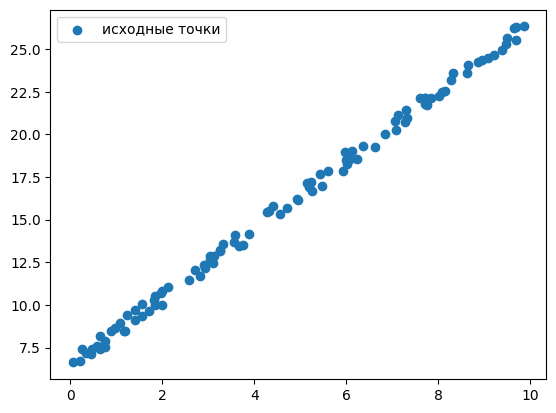

In [ ]:
n = 100
slope = 2
bias = 6
mult = 10
oos_2_bias = 10

x = np.random.random(n)*mult
y = x * slope + bias + np.random.random(n)

sc = plt.scatter(x, y, label='исходные точки')
_ = plt.legend()

Сгенерим еще пару OOS для теста

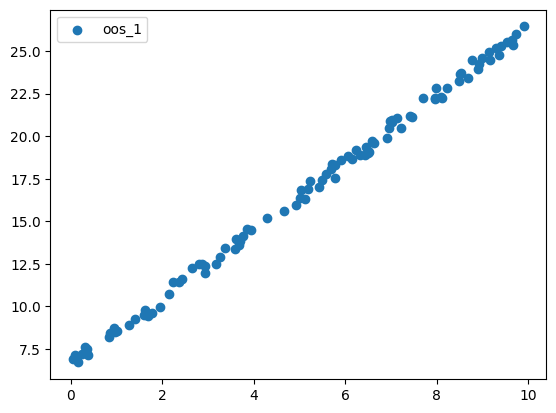

In [ ]:
oos_x_1 = np.random.random(n)*mult
oos_y_1 = oos_x_1 * slope + bias + np.random.random(n)
_ = plt.scatter(oos_x_1, oos_y_1, label = 'oos_1')
_ = plt.legend()

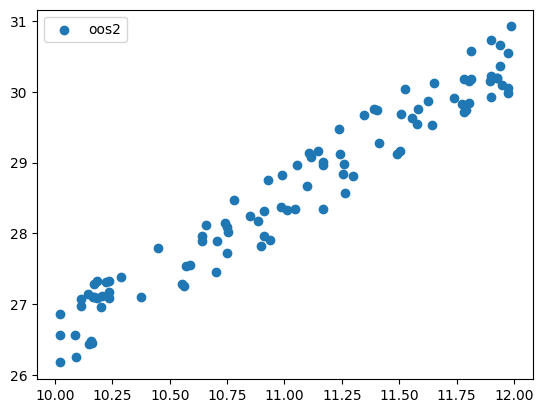

In [ ]:
oos_x_2 = (np.random.random(n)*slope + oos_2_bias )
oos_y_2 = oos_x_2 * slope + bias + np.random.random(n)
_ = plt.scatter(oos_x_2, oos_y_2, label = 'oos2')
plt.legend()

А теперь все вместе

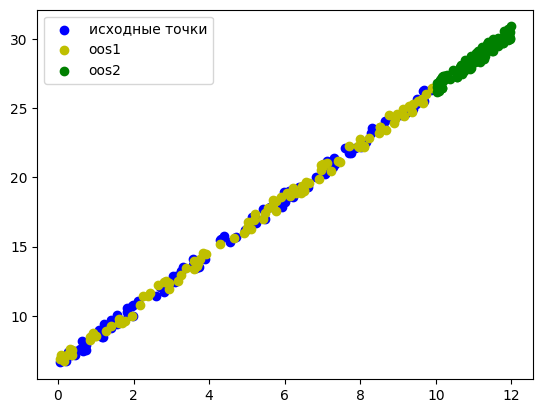

In [ ]:
plt.scatter(x, y, c = 'b', label = 'исходные точки')
plt.scatter(oos_x_1, oos_y_1, c = 'y', label = 'oos1')
plt.scatter(oos_x_2, oos_y_2, c = 'g', label = 'oos2')
_ = plt.legend()

Проверим как линейная регрессия справится с обоими тестовыми множествами

0.9974842479666531
0.9438305194669981


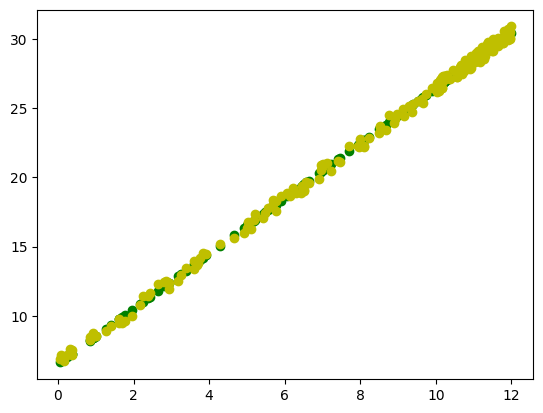

In [ ]:
lr = LinearRegression()
lr.fit(x.reshape(-1,1), y)

print(lr.score(oos_x_1.reshape(-1,1), oos_y_1))
print(lr.score(oos_x_2.reshape(-1,1), oos_y_2))

_ = plt.scatter(oos_x_1, lr.predict(oos_x_1.reshape(-1,1)), c='g')
_ = plt.scatter(oos_x_2, lr.predict(oos_x_2.reshape(-1,1)), c='g')
_ = plt.scatter(oos_x_1, oos_y_1, c='y')
_ = plt.scatter(oos_x_2, oos_y_2, c='y')

Линейная регрессия справилась отлично! Теперь подключим LGBM



In [ ]:
dt = XGBRegressor()
_ = dt.fit(x.reshape(-1,1),y, verbose = False)
print(dt.score(oos_x_1.reshape(-1,1), oos_y_1))
print(dt.score(oos_x_2.reshape(-1,1), oos_y_2))

0.9943678637859522
-3.2194567439466404


Ого! кто скажет что случилось?

Нарисуем?

0.9943678637859522
-3.2194567439466404


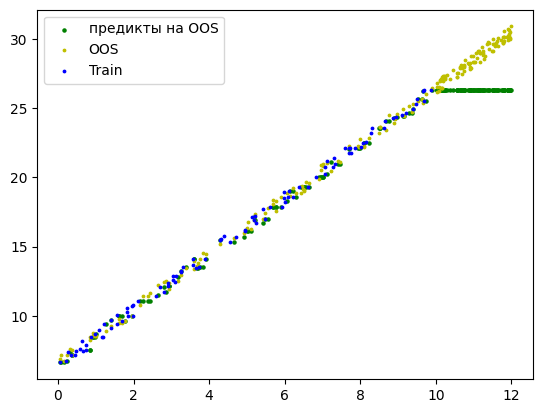

In [ ]:
print(dt.score(oos_x_1.reshape(-1,1), oos_y_1))
print(dt.score(oos_x_2.reshape(-1,1), oos_y_2))
plt.scatter(oos_x_1, dt.predict(oos_x_1.reshape(-1,1)), c='g', label='предикты на OOS', s = 5)
plt.scatter(oos_x_2, dt.predict(oos_x_2.reshape(-1,1)), c='g', s = 5)
plt.scatter(oos_x_1, oos_y_1, c='y', label='OOS', s = 3)
plt.scatter(oos_x_2, oos_y_2, c='y', s = 3)

plt.scatter(x, y, c='b', label='Train', s = 3)
_ = plt.legend()

Кто может объяснить? Как починить?

In [ ]:
dt2 = XGBRegressor(booster = 'gblinear')
_ = dt2.fit(x.reshape(-1,1),y, verbose = False)
print(dt2.score(oos_x_1.reshape(-1,1), oos_y_1))
print(dt2.score(oos_x_2.reshape(-1,1), oos_y_2))

0.9974847932168899
0.9438131201455073


Стало лучше! нарисуем

0.9974847932168899
0.9438131201455073


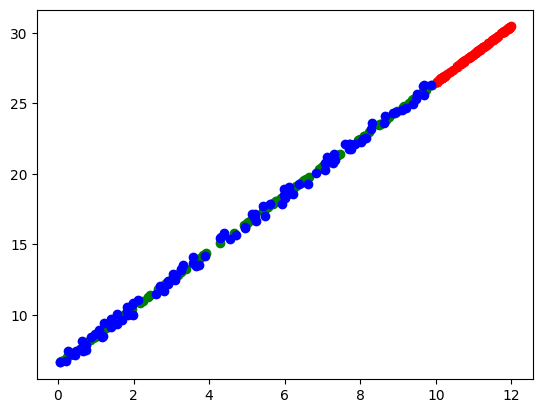

In [ ]:
print(dt2.score(oos_x_1.reshape(-1,1), oos_y_1))
print(dt2.score(oos_x_2.reshape(-1,1), oos_y_2))
_ = plt.scatter(oos_x_1, dt2.predict(oos_x_1.reshape(-1,1)), c='g')
_ = plt.scatter(oos_x_2, dt2.predict(oos_x_2.reshape(-1,1)), c='r')
_ = plt.scatter(x, y, c='b')

А в LightGBM так просто и не починишь )

На подумать -- как именно работает градиентный бустинг над линейными моделями?

Про бизнес? Вы уверены что на инференсе не придет цена больше максимальной из трейна (точнее больше наибольшей средней в листах)?

# Новый раздел

# 2. Еще про границы применимости моделей -- с интерполяцией тоже не так гладко

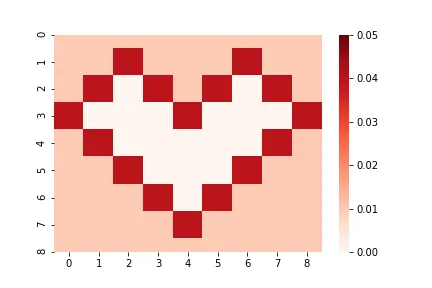

[сердечки в катбусте](https://github.com/catboost/catboost/blob/master/catboost/tutorials/uncertainty/uncertainty_regression.ipynb)

[и еще сердечки](https://towardsdatascience.com/tutorial-uncertainty-estimation-with-catboost-255805ff217e)

[Ын-буст NGBoost](https://stanfordmlgroup.github.io/projects/ngboost/)

In [ ]:
!pip install catboost -q

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
n_features = 10
n_samples = 20000
data = make_regression(n_samples = n_samples, n_features =n_features, random_state = 42)
df = pd.DataFrame(data[0], columns = [f'feature_{k}' for k in range(n_features)])
df['target'] = data[1]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['target'], axis = 1), df['target'], test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
train_pool = Pool(x_train, y_train)
val_pool = Pool(x_val, y_val)
cbr = CatBoostRegressor(
                          loss_function='RMSE', posterior_sampling=True,
                          verbose=False, random_seed=42)
cbr.fit(train_pool, eval_set=val_pool, verbose = False)
print(mean_squared_error(y_test, cbr.predict(x_test)))

87.2493084202163


In [ ]:
model = CatBoostRegressor(
                          loss_function='RMSEWithUncertainty', posterior_sampling=True,
                          verbose=False, random_seed=42)
model.fit(train_pool, eval_set=val_pool)
preds = model.virtual_ensembles_predict(x_test, prediction_type='TotalUncertainty',
                                        virtual_ensembles_count=10)


res = pd.DataFrame(preds, columns = ['predictions', 'knowledge_uncertainty', 'data_uncertainty'], index = x_test.index)
res['target'] = y_test

In [ ]:
print(mean_squared_error(res['target'], res['predictions']))

110.60808659036958


почему вышло хуже?
в ДЗ )

In [ ]:
number_unc_bins = 20
res['unc_bin'] = pd.qcut(res['data_uncertainty'], number_unc_bins, labels = range(0, number_unc_bins))
mse = []
for tr in range(number_unc_bins):
  mse.append(mean_squared_error(res[res['unc_bin'] <= tr]['target'], res[res['unc_bin'] <= tr]['predictions']))

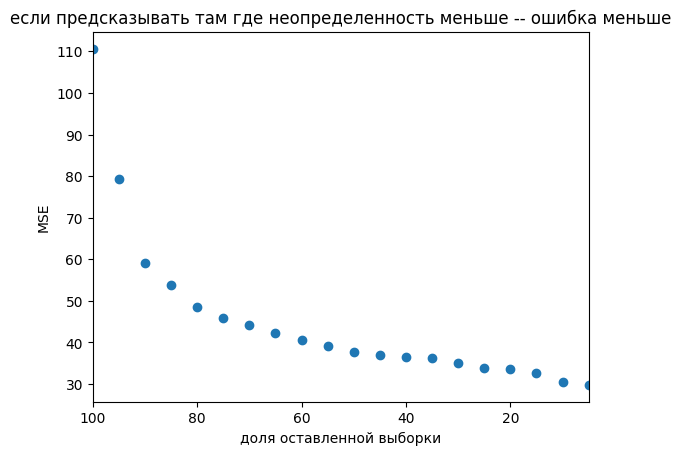

In [ ]:
x_axis = np.linspace(5, 100, 20)
_ = plt.scatter(x_axis, mse)
plt.xlim(max(x_axis), min(x_axis))
plt.xlabel('доля оставленной выборки')
plt.ylabel('MSE')
plt.title('если предсказывать там где неопределенность меньше -- ошибка меньше')
plt.show()

Развитие подхода -- использовать не только оценку самого алгоритма, но и строить другую модель, которая на каждом семпле будет предсказывать ошибки текущей. Широко используется в банках как замена мониторинга моделей -- MPP

Например, в [статье](https://habr.com/ru/companies/vtb/articles/505892/) коллег из ВТБ

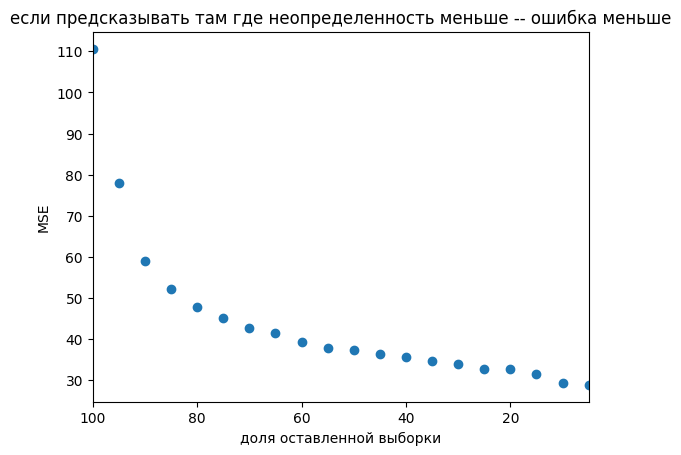

In [ ]:
res['total_uncertaincy'] = res['data_uncertainty'] + res['knowledge_uncertainty']
number_unc_bins = 20
res['unc_bin_total'] = pd.qcut(res['total_uncertaincy'], number_unc_bins, labels = range(0, number_unc_bins))
mse_total = []
for tr in range(number_unc_bins):
  mse_total.append(mean_squared_error(res[res['unc_bin_total'] <= tr]['target'], res[res['unc_bin_total'] <= tr]['predictions']))
x_axis = np.linspace(5, 100, 20)
_ = plt.scatter(x_axis, mse_total)
plt.xlim(max(x_axis), min(x_axis))
plt.xlabel('доля оставленной выборки')
plt.ylabel('MSE')
plt.title('если предсказывать там где неопределенность меньше -- ошибка меньше')
plt.show()

# 3. Раз уж зашло про деревянные алгоритмы -- у них тоже есть особенности


немного про RF

In [ ]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n_features = 500
n_samples = 2000
data = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42, n_redundant = n_features - n_features // 4)
df = pd.DataFrame(data[0], columns = [f'feature_{k}' for k in range(n_features)])
df['target'] = data[1]
df['feature_1'] = df['target'] + 0.5* df['feature_1']
df.rename(columns={'feature_1':'killer'}, inplace = True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size=0.33, random_state=42)

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train, y_train,)
print(rf.score(x_test, y_test))

0.95


In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier(random_state=42)

In [ ]:
dtc.fit(x_train, y_train)
print(dtc.score(x_test, y_test))

0.990909090909091


Почему единичное дерево лучше работает?

In [ ]:
sorted([[col, imp] for imp, col in zip(rf.feature_importances_, \
                                       df.drop('target', axis = 1).columns)], key = lambda x :x[1], reverse=True)[0:5]

[['killer', 0.09490389581971835],
 ['feature_324', 0.027331201244828594],
 ['feature_197', 0.027330275334180927],
 ['feature_182', 0.02678941890217905],
 ['feature_437', 0.026119710006577982]]

In [ ]:
sorted([[col, imp] for imp, col in zip(dtc.feature_importances_, \
                                       df.drop('target', axis = 1).columns)], key = lambda x :x[1], reverse=True)[0:5]

[['killer', 0.9210908320087833],
 ['feature_360', 0.05260854827649881],
 ['feature_86', 0.009594904103468391],
 ['feature_87', 0.007859780357089079],
 ['feature_370', 0.0029802588513088406]]

Почему так?
RF стоит на трех китах:

*   subsampling (выкидываем часть точек при построении очередного дерева),
*   subspacing (выкидываем часть фичей при построении очередного дерева),
*   voting (осредняем предикты всех деревьев)

Ситуации когда хорошая фича или важная группа сэмплов падает жертвой bagging / undersampling etc -- более чем частая


# 4. Фит-предикт -- путь к провалу

In [ ]:
!pip install catboost -q

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)
n_samples = 10000

x = np.linspace(0, 10, n_samples).reshape(-1, 1)
y = 3 * np.sin(x) * x + 10 * x + np.random.normal(0, 0.5, size=(n_samples, 1))

df = pd.DataFrame({'feature': x.flatten(), 'target': y.flatten()})

df['feature'] = df['feature'] ** 2
x_train, x_test, y_train, y_test = train_test_split(df[['feature']], df['target'], test_size=0.2, random_state=42)

train_pool = Pool(x_train, y_train)

Кто-нибудь помнит как выбираются делаются сплиты?

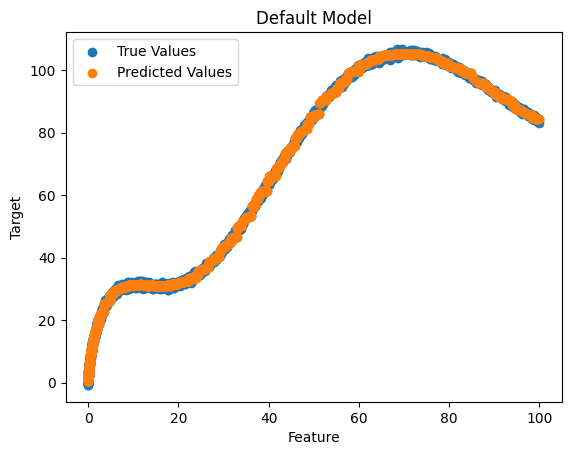

Default Model - Mean Squared Error: 0.47853450806524234


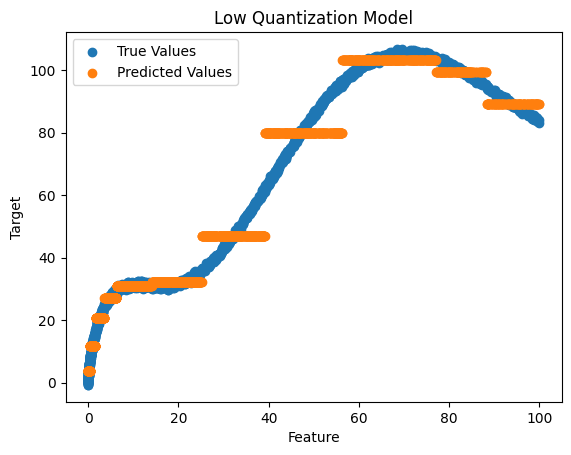

Low Quantization Model - Mean Squared Error: 24.644833954656363


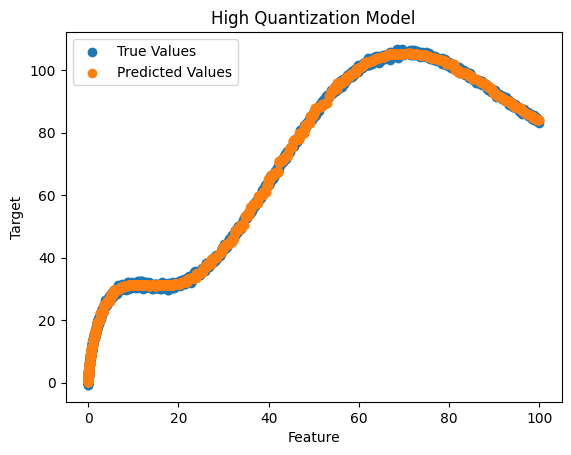

High Quantization Model - Mean Squared Error: 0.41753111300087403


In [ ]:
catboost_params_default = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',
}

catboost_params_custom_low_quantization = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',
    'per_float_feature_quantization': ['0:border_count=10'],  # Low quantization
}

catboost_params_custom_high_quantization = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',
    'per_float_feature_quantization': ['0:border_count=4096'],  # High quantization
}

models = []

model_default = CatBoostRegressor(**catboost_params_default)
model_default.fit(train_pool, verbose = False)
models.append(('Default', model_default))

model_low_quantization = CatBoostRegressor(**catboost_params_custom_low_quantization)
model_low_quantization.fit(train_pool, verbose = False)
models.append(('Low Quantization', model_low_quantization))

model_high_quantization = CatBoostRegressor(**catboost_params_custom_high_quantization)
model_high_quantization.fit(train_pool, verbose = False)
models.append(('High Quantization', model_high_quantization))

mse_array = {}

for model_name, model in models:
    y_pred = model.predict(x_test)

    plt.scatter(x_test, y_test, label='True Values')
    plt.scatter(x_test, y_pred, label='Predicted Values')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.title(f'{model_name} Model')
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    mse_array[model_name] = mse
    print(f'{model_name} Model - Mean Squared Error: {mse}')

Golden features? Quantization?

Это не про глубину деревьев и не про их число

In [ ]:
round((1 - mse_array['High Quantization'] / mse_array['Default']) * 100)

13

На 13% уменьшили ошибку

---





[Пример когда дефолтное число сплитов сломало ценообразование на маркетплейсе](https://habr.com/ru/articles/760550/)



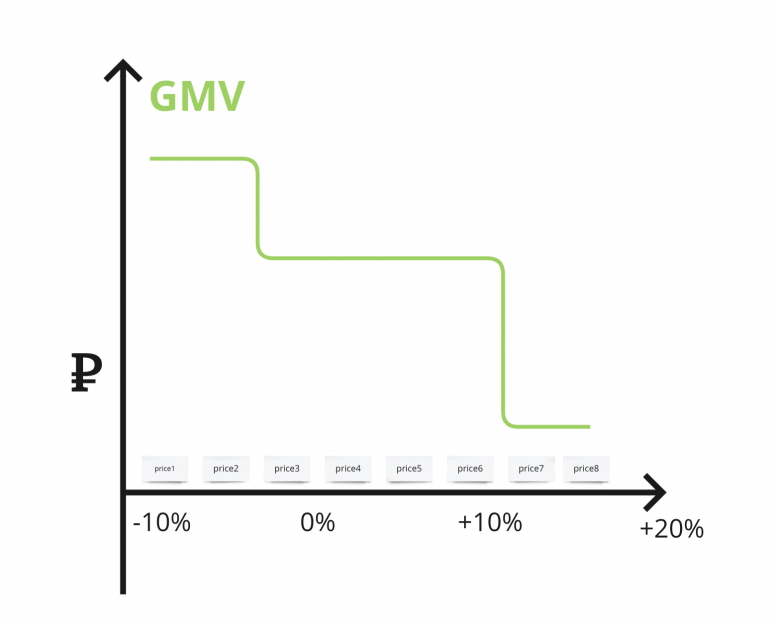

# 5. Как валидироваться

ML в бизнесе это в тч про то, чтобы деливерить стабильный прогнозируемый результат, и у каждой бизнес-задачи могут быть свои требования к проверке моделей перед их использованием.

В курсе мы подробно рассмотрим как в бизнес-задачах проверяют модель на

*   Переобученность
*   Стабильность во времени в смысле
    *   Data drift (часто называют Covariate shift)
    *   Concept Drift (posterior shift)
    *   Target shift (label shift, prior shift)
*   Соответсвие бизнес-логике и монотонным ограничениям
*   Интерпретируемость
*   Уверенность модели в ответе (uncertaincy и confidence)

а пока рассмотрим базовые подходы к валидации моделей  (с учетом что вы уже знаете про кросс-валидацию, метрики и отложенный тест)



## 5.1. Stratified vs group k-fold

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
x, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    n_clusters_per_class=1,
    flip_y=0.1,
    random_state=42
)

num_groups = 10
group_ids = np.random.randint(num_groups, size=len(y))

data = pd.DataFrame(data={'feature_{}'.format(i): x[:, i] for i in range(x.shape[1])})
data['target'] = y
data['group_id'] = group_ids
cnt_dict = dict(data['group_id'].value_counts())
print(data.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  target  group_id
0   0.798544   2.280978  -0.822322   0.288411  -3.418566       1         6
1   1.405951   0.664275   0.451591  -0.704822   0.577618       1         3
2  -1.964415   1.325393   0.827029   1.040189  -0.808016       0         7
3   1.792585   1.604088  -0.271690  -0.134156  -1.431986       1         4
4  -1.246207   0.364518   0.128635  -0.358704  -0.654848       1         6


Как правильно тестироваться?   
Группы постоянные (ex: Регионы)?   




Fold 1:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10

Fold 2:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10

Fold 3:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10

Fold 4:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10

Fold 5:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10


Text(0.5, 0.98, 'доли групп в трейне')

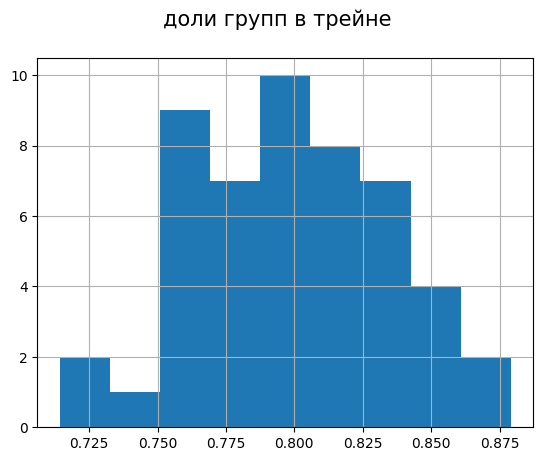

In [ ]:
from sklearn.model_selection import StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ratios = []
for fold, (train_indices, test_indices) in enumerate(k_fold.split(x, y, group_ids)):
    print(f"\nFold {fold + 1}:")
    print(f"Training samples: {len(train_indices)}")
    print(f"Testing samples: {len(test_indices)}")
    print(f"Unique groups in training set: {len(np.unique(group_ids[train_indices]))}")
    print(f"Unique groups in testing set: {len(np.unique(group_ids[test_indices]))}")

    train_cnt_dict = dict(pd.Series(group_ids[train_indices]).value_counts())
    for group in train_cnt_dict:
      ratios.append(train_cnt_dict[group] * 1.0 / cnt_dict[group])
fig = plt.figure()
pd.Series(ratios).hist(bins = 9)
fig.suptitle('доли групп в трейне', fontsize=15)

Или на инференсе новая группа может придти (в ЖК есть корпуса а в них квартиры)?

In [ ]:
from sklearn.model_selection import GroupKFold
k_fold = GroupKFold(n_splits=5)

for fold, (train_indices, test_indices) in enumerate(k_fold.split(x, y, group_ids)):
    print(f"\nFold {fold + 1}:")
    print(f"Training samples: {len(train_indices)}")
    print(f"Testing samples: {len(test_indices)}")
    print(f"Unique groups in training set: {len(np.unique(group_ids[train_indices]))}")
    print(f"Unique groups in testing set: {len(np.unique(group_ids[test_indices]))}")


Fold 1:
Training samples: 799
Testing samples: 201
Unique groups in training set: 8
Unique groups in testing set: 2

Fold 2:
Training samples: 799
Testing samples: 201
Unique groups in training set: 8
Unique groups in testing set: 2

Fold 3:
Training samples: 799
Testing samples: 201
Unique groups in training set: 8
Unique groups in testing set: 2

Fold 4:
Training samples: 799
Testing samples: 201
Unique groups in training set: 8
Unique groups in testing set: 2

Fold 5:
Training samples: 804
Testing samples: 196
Unique groups in training set: 8
Unique groups in testing set: 2


чтобы в явном виде задать сколько групп не включать в тексст -- [Leave P Groups Out](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.LeavePGroupsOut.html#sklearn.model_selection.LeavePGroupsOut)

## 5.2 Двойная кросс-валидация

Утащено [отсюда](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
random_state = 42
# create dataset
x, y = make_classification(n_samples=1000, n_features=20, random_state=1, n_informative=10, n_redundant=10)
# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=random_state)
# define the model
model = RandomForestClassifier(random_state=random_state)
# define search space
space = dict()
space['n_estimators'] = [10, 100]
space['max_features'] = [2, 4, 6]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=3, shuffle=True, random_state=1) # 10
# execute the nested cross-validation
scores = cross_val_score(search, x, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.927 (0.004)
CPU times: user 120 ms, sys: 52.3 ms, total: 173 ms
Wall time: 8.85 s


А вообще только в [2018](https://arxiv.org/abs/1809.09446) поставили точку в нужности такого приема (а их было много -- CV со взвешиваниями, со штрафами (V-Fold CV with penalty) и пр.)

## 5.3. Валидация с учетом времени

Простая схема с OOT
[отсюда](https://forecastegy.com/posts/time-series-cross-validation-python/)
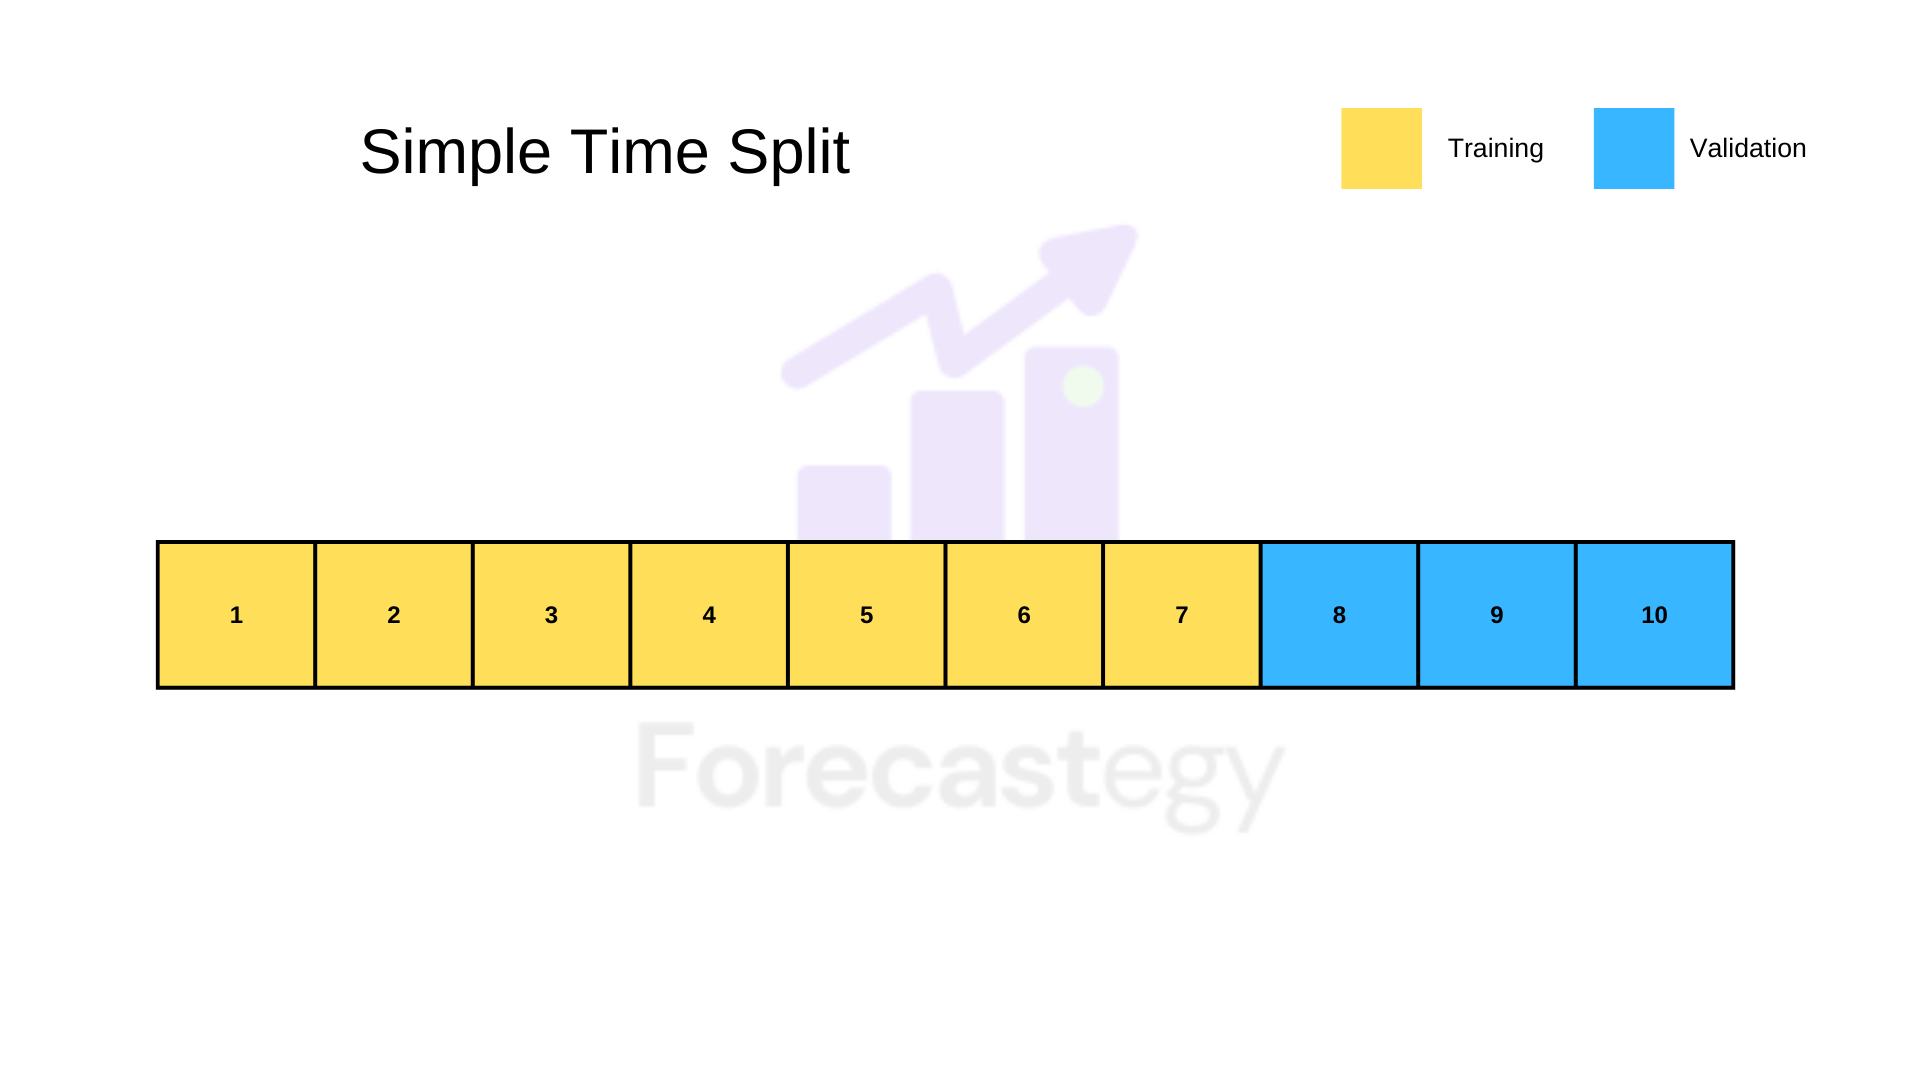

Схема скользящего окна
[отсюда](https://forecastegy.com/posts/time-series-cross-validation-python/)

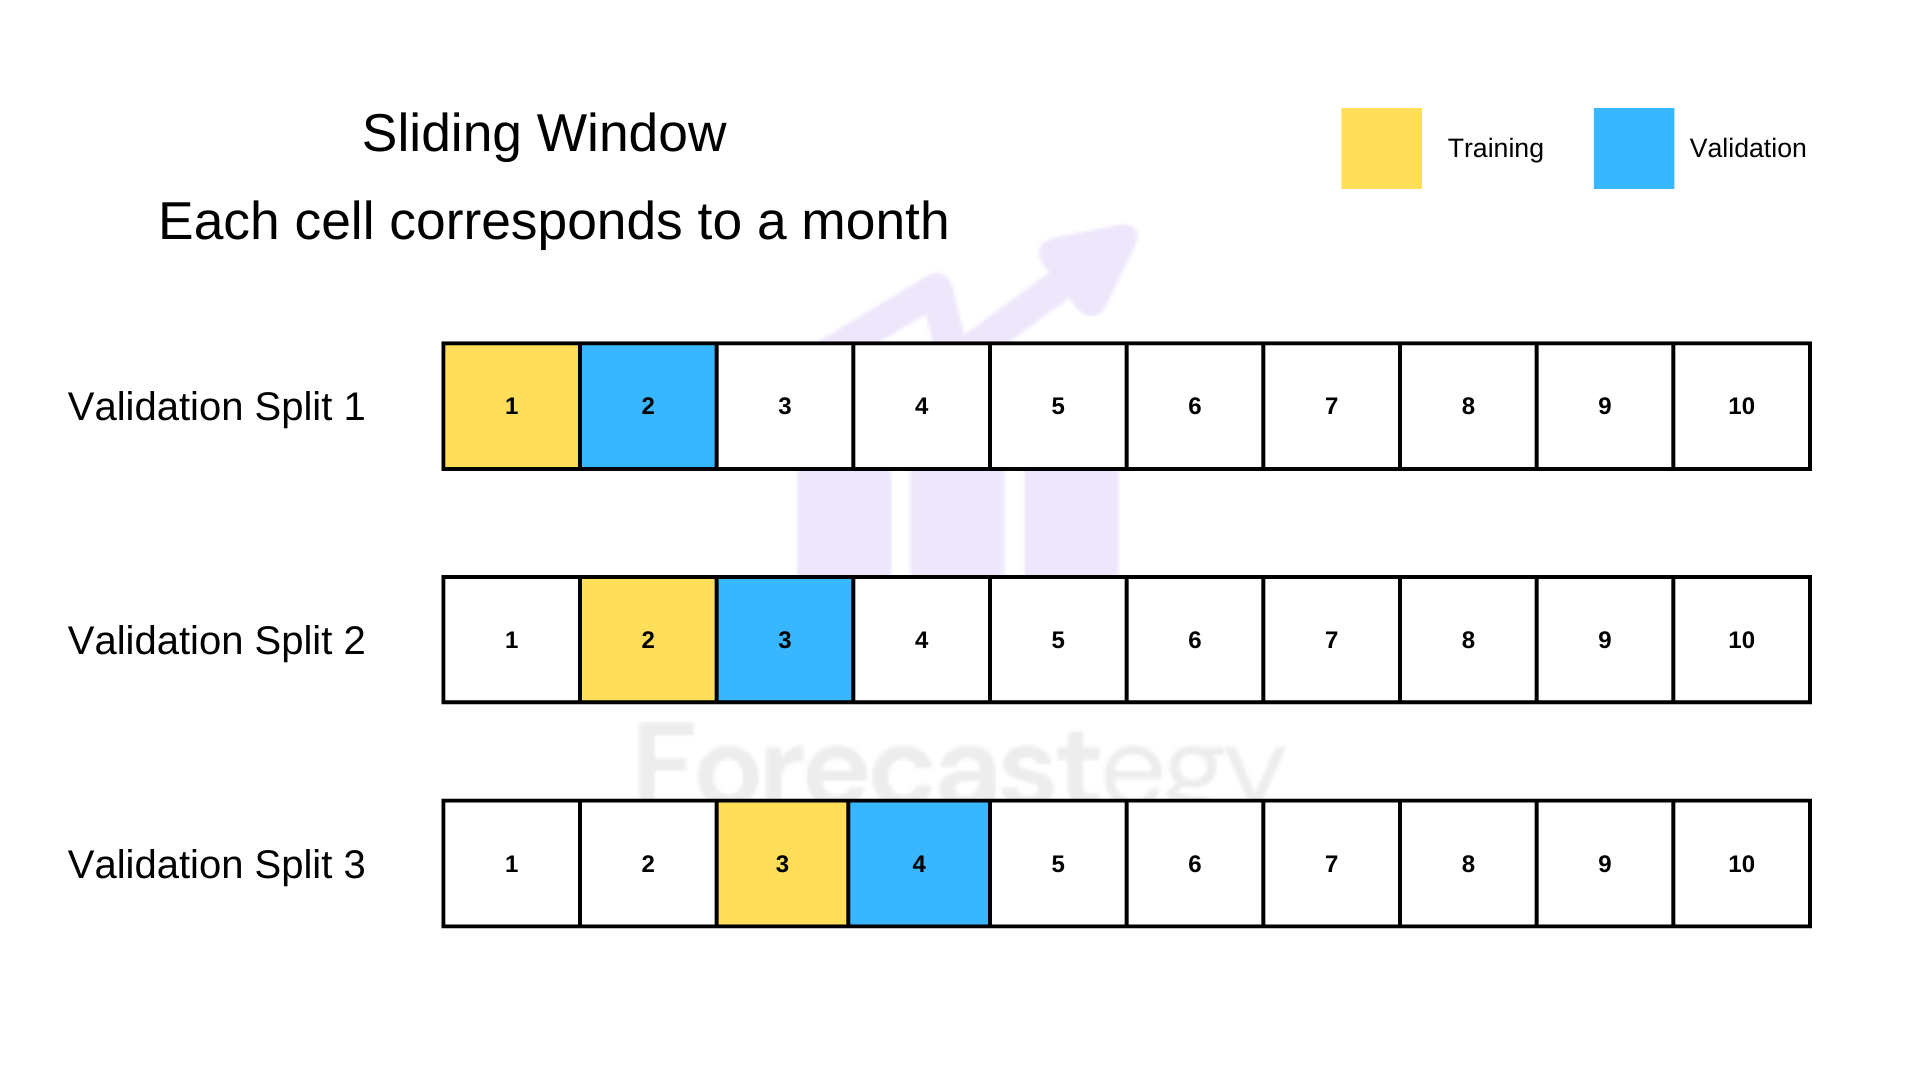

Схема расширяющегося скользящего окна
[отсюда](https://forecastegy.com/posts/time-series-cross-validation-python/)

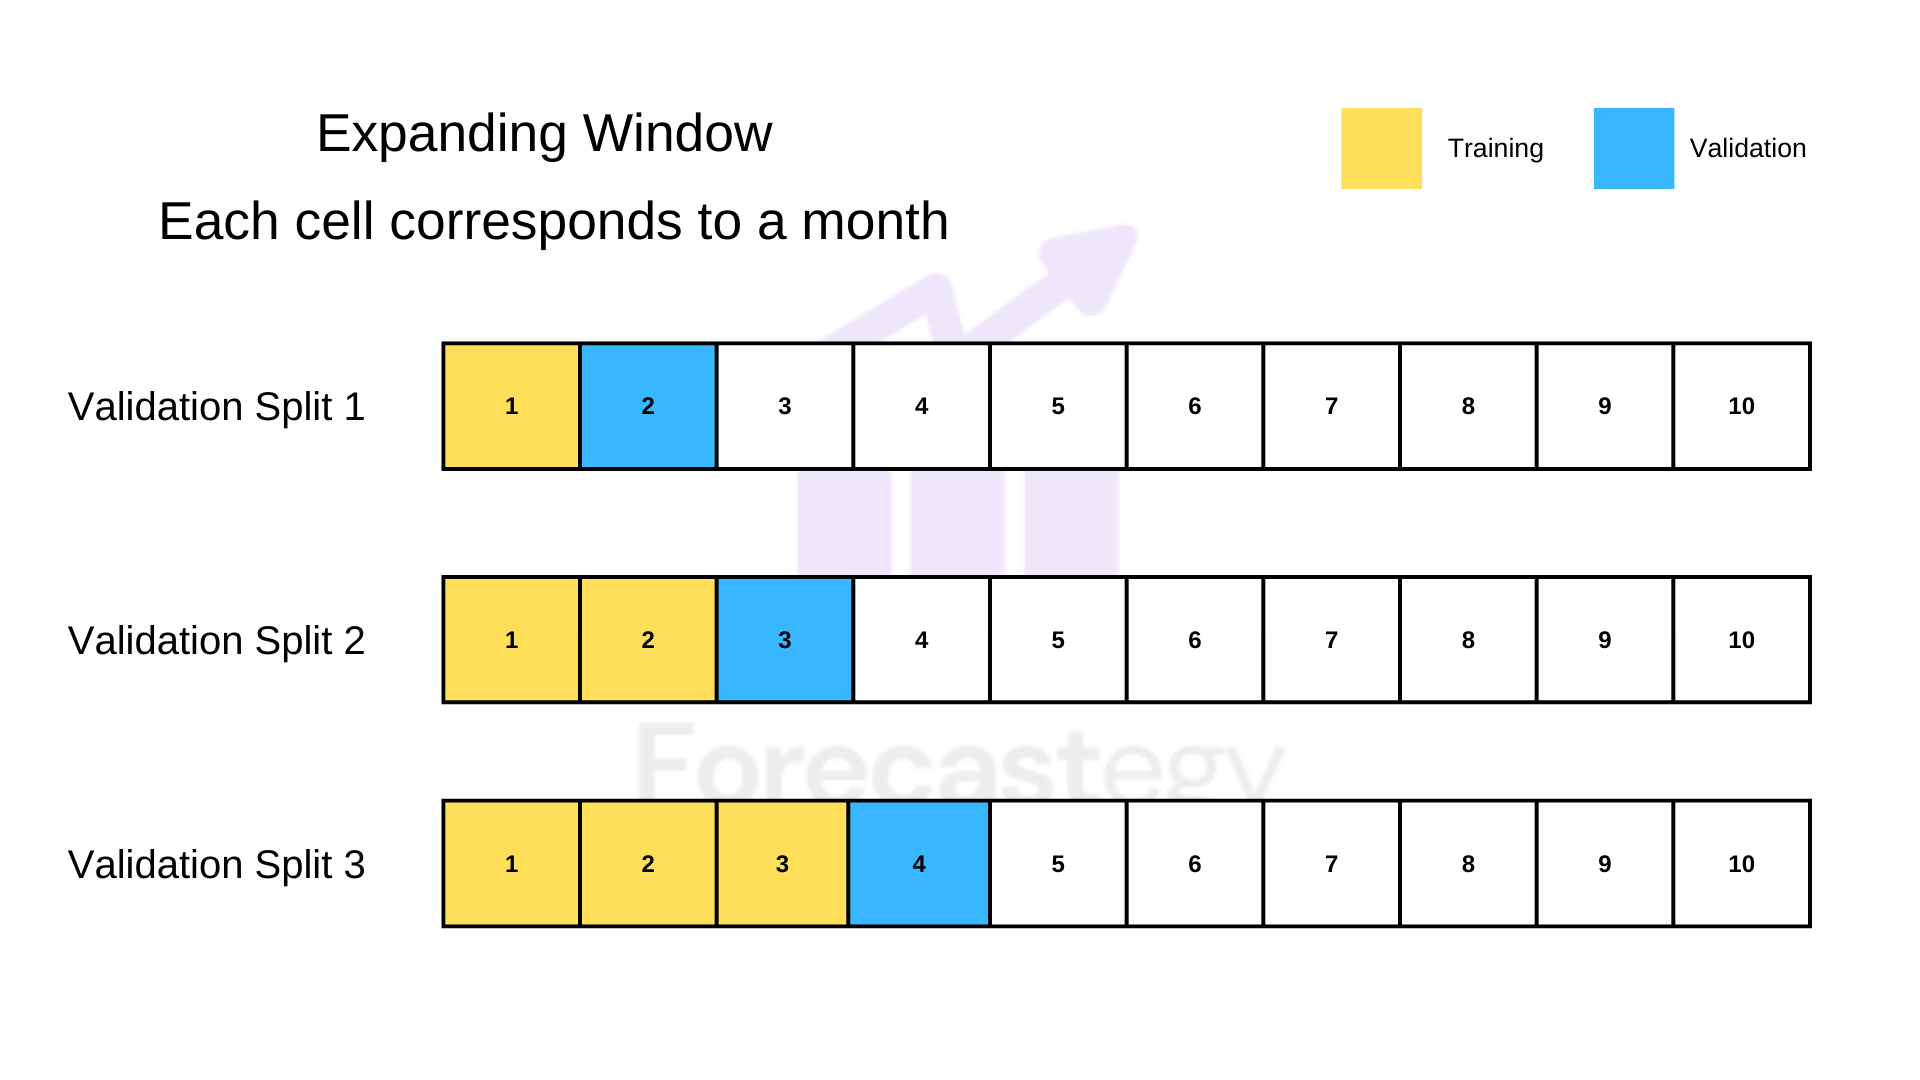

Схема скользящего окна с зазором
[отсюда](https://forecastegy.com/posts/time-series-cross-validation-python/)

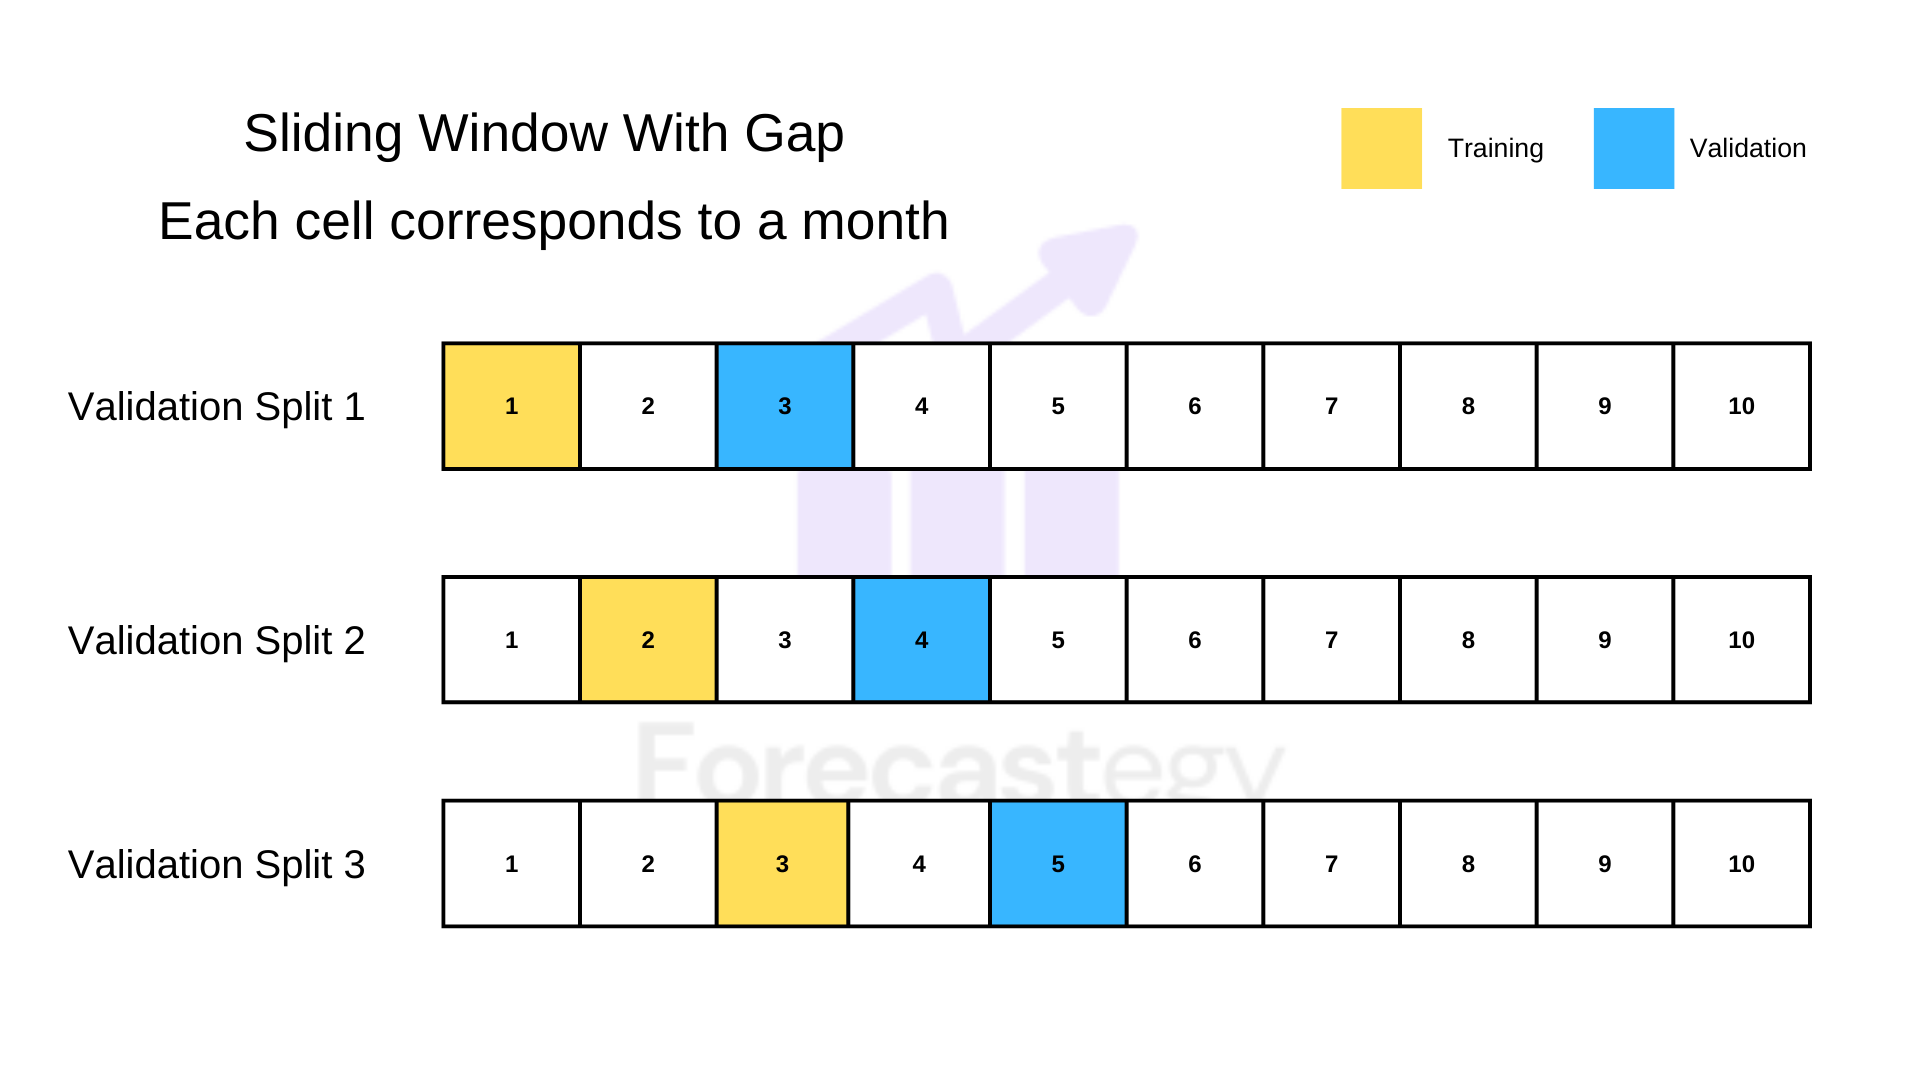

Какая схема чаще всего на практике?

Очень важно запомнить последнюю и всегда учитывать лаг источника как при сборке трейна, так и при валидации!

Параметр Gap уже появился и в sklearn в [TimeSeriesSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

## 5.4. Валидация двухэтапной модели

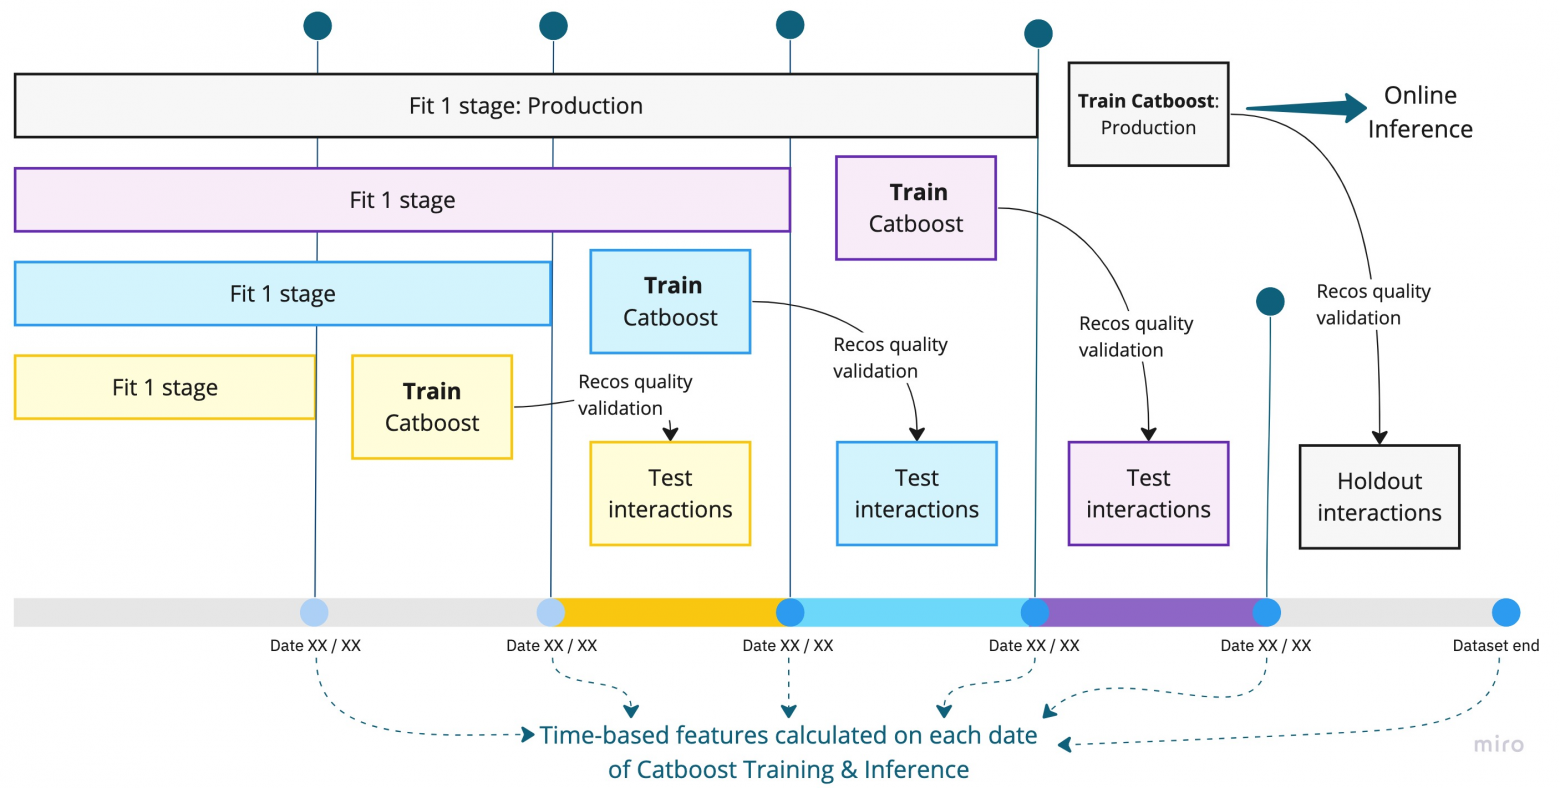


чуть детальнее про такие модели в рекомендациях [в блоге МТС на habr](https://habr.com/ru/companies/ods/articles/756874/)

## 5.5. Repeated k-fold

In [ ]:
import lightgbm as lgb
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform
from sklearn.metrics import accuracy_score
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Пара экспериментов

### Эксперимент 1.

Разделим выборку на train и test.      
И на трейне будем через cv подбирать гиперпараметры, задав не по сетке всего один -- L2-регуляризию весов листьев в бустинге и подбирая его через RandomizedSearch.

Попробуем проверить, что произойдет с точностью модели если попробовать 200 разных random_state только для этой процедуры -- все остальное (разделение на train/test, сетка параметров и пр. -- абсолютно одинаковое)

In [ ]:
%%time
res_test_metrics = []
x, y = make_classification(n_samples=5000, n_features=20, random_state=1, n_informative=10, n_redundant=10)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

for random_state in tqdm(range(200)):
  bst = lgb.LGBMClassifier()
  hyper_space = dict(max_depth = [10, 15]
                    , n_estimators = [50, 100, 200]
                    , reg_lambda = uniform(), verbose = [-1], num_leaves=[32])
  clf = RandomizedSearchCV(bst, hyper_space, random_state=random_state)
  search = clf.fit(x_train, y_train)
  bst = lgb.LGBMClassifier(**search.best_params_)
  bst.fit(x_train, y_train)
  res_test_metrics.append(accuracy_score(bst.predict(x_test), y_test))
  print('accuracy ',  res_test_metrics[-1])

  0%|          | 1/200 [00:39<2:11:15, 39.57s/it]

accuracy  0.959


  1%|          | 2/200 [01:11<1:55:14, 34.92s/it]

accuracy  0.957


  2%|▏         | 3/200 [01:38<1:42:31, 31.23s/it]

accuracy  0.961


  2%|▏         | 4/200 [02:06<1:37:51, 29.95s/it]

accuracy  0.961


  2%|▎         | 5/200 [02:36<1:37:32, 30.01s/it]

accuracy  0.961


  3%|▎         | 6/200 [03:05<1:36:24, 29.82s/it]

accuracy  0.955


  4%|▎         | 7/200 [03:32<1:32:55, 28.89s/it]

accuracy  0.955


  4%|▍         | 8/200 [04:00<1:31:29, 28.59s/it]

accuracy  0.955


  4%|▍         | 9/200 [04:37<1:39:14, 31.17s/it]

accuracy  0.96


  5%|▌         | 10/200 [05:10<1:40:42, 31.80s/it]

accuracy  0.957


  6%|▌         | 11/200 [05:42<1:40:09, 31.80s/it]

accuracy  0.962


  6%|▌         | 12/200 [06:13<1:39:07, 31.63s/it]

accuracy  0.96


  6%|▋         | 13/200 [06:44<1:38:08, 31.49s/it]

accuracy  0.955


  7%|▋         | 14/200 [07:09<1:30:55, 29.33s/it]

accuracy  0.956


  8%|▊         | 15/200 [07:34<1:26:29, 28.05s/it]

accuracy  0.958


  8%|▊         | 16/200 [08:06<1:29:29, 29.18s/it]

accuracy  0.957


  8%|▊         | 17/200 [08:35<1:29:34, 29.37s/it]

accuracy  0.958


  9%|▉         | 18/200 [09:03<1:27:24, 28.81s/it]

accuracy  0.958


 10%|▉         | 19/200 [09:30<1:25:24, 28.31s/it]

accuracy  0.958


 10%|█         | 20/200 [10:06<1:31:38, 30.54s/it]

accuracy  0.961


 10%|█         | 21/200 [10:40<1:34:02, 31.52s/it]

accuracy  0.958


 11%|█         | 22/200 [11:04<1:26:49, 29.27s/it]

accuracy  0.958


 12%|█▏        | 23/200 [11:29<1:22:43, 28.04s/it]

accuracy  0.957


 12%|█▏        | 24/200 [12:04<1:28:20, 30.12s/it]

accuracy  0.962


 12%|█▎        | 25/200 [12:35<1:28:57, 30.50s/it]

accuracy  0.959


 13%|█▎        | 26/200 [13:06<1:29:05, 30.72s/it]

accuracy  0.958


 14%|█▎        | 27/200 [13:34<1:25:34, 29.68s/it]

accuracy  0.957


 14%|█▍        | 28/200 [14:05<1:26:27, 30.16s/it]

accuracy  0.956


 14%|█▍        | 29/200 [14:27<1:19:28, 27.88s/it]

accuracy  0.958


 15%|█▌        | 30/200 [14:54<1:17:56, 27.51s/it]

accuracy  0.958


 16%|█▌        | 31/200 [15:26<1:21:03, 28.78s/it]

accuracy  0.959


 16%|█▌        | 32/200 [15:50<1:17:06, 27.54s/it]

accuracy  0.957


 16%|█▋        | 33/200 [16:18<1:16:32, 27.50s/it]

accuracy  0.956


 17%|█▋        | 34/200 [16:45<1:16:05, 27.50s/it]

accuracy  0.962


 18%|█▊        | 35/200 [17:15<1:17:00, 28.00s/it]

accuracy  0.96


 18%|█▊        | 36/200 [17:43<1:16:45, 28.09s/it]

accuracy  0.957


 18%|█▊        | 37/200 [18:10<1:15:38, 27.84s/it]

accuracy  0.959


 19%|█▉        | 38/200 [18:39<1:15:52, 28.10s/it]

accuracy  0.961


 20%|█▉        | 39/200 [19:08<1:16:25, 28.48s/it]

accuracy  0.953


 20%|██        | 40/200 [19:34<1:13:32, 27.58s/it]

accuracy  0.959


 20%|██        | 41/200 [20:03<1:14:24, 28.08s/it]

accuracy  0.96


 21%|██        | 42/200 [20:29<1:12:29, 27.53s/it]

accuracy  0.959


 22%|██▏       | 43/200 [20:55<1:10:59, 27.13s/it]

accuracy  0.959


 22%|██▏       | 44/200 [21:23<1:11:06, 27.35s/it]

accuracy  0.957


 22%|██▎       | 45/200 [21:54<1:13:08, 28.31s/it]

accuracy  0.96


 23%|██▎       | 46/200 [22:20<1:10:51, 27.61s/it]

accuracy  0.959


 24%|██▎       | 47/200 [22:46<1:09:08, 27.12s/it]

accuracy  0.959


 24%|██▍       | 48/200 [23:15<1:10:12, 27.72s/it]

accuracy  0.956


 24%|██▍       | 49/200 [23:38<1:05:58, 26.22s/it]

accuracy  0.959


 25%|██▌       | 50/200 [24:06<1:07:00, 26.80s/it]

accuracy  0.955


 26%|██▌       | 51/200 [24:29<1:04:18, 25.89s/it]

accuracy  0.959


 26%|██▌       | 52/200 [24:50<1:00:12, 24.41s/it]

accuracy  0.963


 26%|██▋       | 53/200 [25:20<1:03:37, 25.97s/it]

accuracy  0.959


 27%|██▋       | 54/200 [25:47<1:03:38, 26.15s/it]

accuracy  0.959


 28%|██▊       | 55/200 [26:14<1:04:11, 26.56s/it]

accuracy  0.958


 28%|██▊       | 56/200 [26:43<1:05:41, 27.37s/it]

accuracy  0.956


 28%|██▊       | 57/200 [27:07<1:02:47, 26.35s/it]

accuracy  0.963


 29%|██▉       | 58/200 [27:33<1:01:40, 26.06s/it]

accuracy  0.957


 30%|██▉       | 59/200 [28:01<1:03:04, 26.84s/it]

accuracy  0.958


 30%|███       | 60/200 [28:32<1:05:08, 27.92s/it]

accuracy  0.958


 30%|███       | 61/200 [28:54<1:00:58, 26.32s/it]

accuracy  0.957


 31%|███       | 62/200 [29:24<1:02:59, 27.39s/it]

accuracy  0.962


 32%|███▏      | 63/200 [29:51<1:02:22, 27.32s/it]

accuracy  0.961


 32%|███▏      | 64/200 [30:20<1:03:01, 27.80s/it]

accuracy  0.961


 32%|███▎      | 65/200 [30:46<1:01:14, 27.22s/it]

accuracy  0.96


 33%|███▎      | 66/200 [31:09<57:35, 25.79s/it]  

accuracy  0.957


 34%|███▎      | 67/200 [31:37<58:47, 26.52s/it]

accuracy  0.958


 34%|███▍      | 68/200 [32:06<1:00:19, 27.42s/it]

accuracy  0.956


 34%|███▍      | 69/200 [32:37<1:01:51, 28.33s/it]

accuracy  0.96


 35%|███▌      | 70/200 [33:02<59:34, 27.50s/it]  

accuracy  0.955


 36%|███▌      | 71/200 [33:28<57:57, 26.96s/it]

accuracy  0.96


 36%|███▌      | 72/200 [33:58<59:18, 27.80s/it]

accuracy  0.956


 36%|███▋      | 73/200 [34:24<57:28, 27.16s/it]

accuracy  0.96


 37%|███▋      | 74/200 [34:50<56:36, 26.96s/it]

accuracy  0.96


 38%|███▊      | 75/200 [35:20<57:47, 27.74s/it]

accuracy  0.957


 38%|███▊      | 76/200 [35:45<55:39, 26.93s/it]

accuracy  0.958


 38%|███▊      | 77/200 [36:15<56:59, 27.80s/it]

accuracy  0.955


 39%|███▉      | 78/200 [36:41<55:53, 27.49s/it]

accuracy  0.958


 40%|███▉      | 79/200 [37:07<54:04, 26.81s/it]

accuracy  0.962


 40%|████      | 80/200 [37:35<54:34, 27.28s/it]

accuracy  0.963


 40%|████      | 81/200 [38:03<54:36, 27.53s/it]

accuracy  0.958


 41%|████      | 82/200 [38:36<57:19, 29.15s/it]

accuracy  0.954


 42%|████▏     | 83/200 [39:03<55:33, 28.49s/it]

accuracy  0.96


 42%|████▏     | 84/200 [39:31<54:43, 28.31s/it]

accuracy  0.961


 42%|████▎     | 85/200 [39:55<51:50, 27.04s/it]

accuracy  0.958


 43%|████▎     | 86/200 [40:24<52:19, 27.54s/it]

accuracy  0.954


 44%|████▎     | 87/200 [40:52<52:20, 27.80s/it]

accuracy  0.958


 44%|████▍     | 88/200 [41:18<50:57, 27.30s/it]

accuracy  0.958


 44%|████▍     | 89/200 [41:47<51:36, 27.90s/it]

accuracy  0.959


 45%|████▌     | 90/200 [42:12<49:20, 26.91s/it]

accuracy  0.96


 46%|████▌     | 91/200 [42:36<47:23, 26.09s/it]

accuracy  0.96


 46%|████▌     | 92/200 [42:58<44:32, 24.75s/it]

accuracy  0.96


 46%|████▋     | 93/200 [43:22<43:39, 24.48s/it]

accuracy  0.962


 47%|████▋     | 94/200 [43:49<44:50, 25.39s/it]

accuracy  0.961


 48%|████▊     | 95/200 [44:12<43:18, 24.75s/it]

accuracy  0.959


 48%|████▊     | 96/200 [44:36<42:13, 24.36s/it]

accuracy  0.959


 48%|████▊     | 97/200 [45:03<43:27, 25.31s/it]

accuracy  0.959


 49%|████▉     | 98/200 [45:29<42:58, 25.28s/it]

accuracy  0.962


 50%|████▉     | 99/200 [45:57<43:57, 26.11s/it]

accuracy  0.958


 50%|█████     | 100/200 [46:22<43:23, 26.04s/it]

accuracy  0.959


 50%|█████     | 101/200 [46:47<42:23, 25.70s/it]

accuracy  0.956


 51%|█████     | 102/200 [47:14<42:32, 26.04s/it]

accuracy  0.961


 52%|█████▏    | 103/200 [47:38<41:00, 25.36s/it]

accuracy  0.958


 52%|█████▏    | 104/200 [48:09<43:02, 26.90s/it]

accuracy  0.96


 52%|█████▎    | 105/200 [48:37<43:06, 27.23s/it]

accuracy  0.96


 53%|█████▎    | 106/200 [49:02<41:49, 26.70s/it]

accuracy  0.957


 54%|█████▎    | 107/200 [49:28<41:01, 26.47s/it]

accuracy  0.954


 54%|█████▍    | 108/200 [49:49<38:11, 24.91s/it]

accuracy  0.957


 55%|█████▍    | 109/200 [50:16<38:33, 25.42s/it]

accuracy  0.961


 55%|█████▌    | 110/200 [50:41<38:03, 25.37s/it]

accuracy  0.956


 56%|█████▌    | 111/200 [51:10<39:15, 26.46s/it]

accuracy  0.962


 56%|█████▌    | 112/200 [51:33<37:07, 25.32s/it]

accuracy  0.957


 56%|█████▋    | 113/200 [51:58<36:38, 25.26s/it]

accuracy  0.957


 57%|█████▋    | 114/200 [52:26<37:27, 26.14s/it]

accuracy  0.957


 57%|█████▊    | 115/200 [52:52<37:00, 26.12s/it]

accuracy  0.96


 58%|█████▊    | 116/200 [53:18<36:40, 26.19s/it]

accuracy  0.957


 58%|█████▊    | 117/200 [53:50<38:28, 27.82s/it]

accuracy  0.96


 59%|█████▉    | 118/200 [54:20<39:04, 28.59s/it]

accuracy  0.955


 60%|█████▉    | 119/200 [54:48<38:08, 28.25s/it]

accuracy  0.958


 60%|██████    | 120/200 [55:09<34:59, 26.24s/it]

accuracy  0.959


 60%|██████    | 121/200 [55:41<36:47, 27.94s/it]

accuracy  0.959


 61%|██████    | 122/200 [56:07<35:29, 27.30s/it]

accuracy  0.957


 62%|██████▏   | 123/200 [56:36<35:45, 27.86s/it]

accuracy  0.959


 62%|██████▏   | 124/200 [57:03<34:47, 27.46s/it]

accuracy  0.958


 62%|██████▎   | 125/200 [57:31<34:28, 27.58s/it]

accuracy  0.963


 63%|██████▎   | 126/200 [57:59<34:20, 27.85s/it]

accuracy  0.955


 64%|██████▎   | 127/200 [58:23<32:32, 26.75s/it]

accuracy  0.962


 64%|██████▍   | 128/200 [58:53<33:14, 27.70s/it]

accuracy  0.957


 64%|██████▍   | 129/200 [59:21<32:39, 27.60s/it]

accuracy  0.961


 65%|██████▌   | 130/200 [59:50<32:53, 28.20s/it]

accuracy  0.961


 66%|██████▌   | 131/200 [1:00:25<34:33, 30.05s/it]

accuracy  0.955


 66%|██████▌   | 132/200 [1:00:53<33:27, 29.52s/it]

accuracy  0.959


 66%|██████▋   | 133/200 [1:01:21<32:33, 29.16s/it]

accuracy  0.96


 67%|██████▋   | 134/200 [1:01:52<32:45, 29.78s/it]

accuracy  0.961


 68%|██████▊   | 135/200 [1:02:24<32:56, 30.41s/it]

accuracy  0.96


 68%|██████▊   | 136/200 [1:02:52<31:29, 29.52s/it]

accuracy  0.961


 68%|██████▊   | 137/200 [1:03:22<31:05, 29.62s/it]

accuracy  0.956


 69%|██████▉   | 138/200 [1:03:46<28:56, 28.00s/it]

accuracy  0.963


 70%|██████▉   | 139/200 [1:04:11<27:43, 27.27s/it]

accuracy  0.962


 70%|███████   | 140/200 [1:04:40<27:36, 27.61s/it]

accuracy  0.961


 70%|███████   | 141/200 [1:05:07<27:05, 27.55s/it]

accuracy  0.958


 71%|███████   | 142/200 [1:05:37<27:13, 28.16s/it]

accuracy  0.958


 72%|███████▏  | 143/200 [1:06:09<27:57, 29.43s/it]

accuracy  0.96


 72%|███████▏  | 144/200 [1:06:41<28:07, 30.14s/it]

accuracy  0.957


 72%|███████▎  | 145/200 [1:07:05<25:57, 28.32s/it]

accuracy  0.958


 73%|███████▎  | 146/200 [1:07:34<25:38, 28.49s/it]

accuracy  0.961


 74%|███████▎  | 147/200 [1:08:04<25:34, 28.96s/it]

accuracy  0.961


 74%|███████▍  | 148/200 [1:08:29<24:11, 27.91s/it]

accuracy  0.957


 74%|███████▍  | 149/200 [1:08:59<24:07, 28.38s/it]

accuracy  0.957


 75%|███████▌  | 150/200 [1:09:25<23:08, 27.77s/it]

accuracy  0.958


 76%|███████▌  | 151/200 [1:09:51<22:09, 27.12s/it]

accuracy  0.956


 76%|███████▌  | 152/200 [1:10:18<21:38, 27.05s/it]

accuracy  0.962


 76%|███████▋  | 153/200 [1:10:43<20:47, 26.54s/it]

accuracy  0.958


 77%|███████▋  | 154/200 [1:11:10<20:18, 26.49s/it]

accuracy  0.957


 78%|███████▊  | 155/200 [1:11:37<20:01, 26.70s/it]

accuracy  0.962


 78%|███████▊  | 156/200 [1:12:03<19:33, 26.66s/it]

accuracy  0.962


 78%|███████▊  | 157/200 [1:12:31<19:16, 26.90s/it]

accuracy  0.958


 79%|███████▉  | 158/200 [1:13:05<20:20, 29.07s/it]

accuracy  0.957


 80%|███████▉  | 159/200 [1:13:32<19:22, 28.35s/it]

accuracy  0.956


 80%|████████  | 160/200 [1:14:03<19:35, 29.38s/it]

accuracy  0.962


 80%|████████  | 161/200 [1:14:27<17:55, 27.57s/it]

accuracy  0.958


 81%|████████  | 162/200 [1:14:54<17:22, 27.44s/it]

accuracy  0.959


 82%|████████▏ | 163/200 [1:15:22<17:00, 27.59s/it]

accuracy  0.963


 82%|████████▏ | 164/200 [1:15:50<16:40, 27.79s/it]

accuracy  0.962


 82%|████████▎ | 165/200 [1:16:15<15:42, 26.93s/it]

accuracy  0.957


 83%|████████▎ | 166/200 [1:16:39<14:50, 26.18s/it]

accuracy  0.954


 84%|████████▎ | 167/200 [1:17:05<14:13, 25.87s/it]

accuracy  0.959


 84%|████████▍ | 168/200 [1:17:33<14:08, 26.53s/it]

accuracy  0.96


 84%|████████▍ | 169/200 [1:17:58<13:29, 26.13s/it]

accuracy  0.96


 85%|████████▌ | 170/200 [1:18:26<13:19, 26.64s/it]

accuracy  0.954


 86%|████████▌ | 171/200 [1:18:52<12:50, 26.56s/it]

accuracy  0.958


 86%|████████▌ | 172/200 [1:19:22<12:53, 27.64s/it]

accuracy  0.956


 86%|████████▋ | 173/200 [1:19:49<12:17, 27.32s/it]

accuracy  0.963


 87%|████████▋ | 174/200 [1:20:19<12:11, 28.13s/it]

accuracy  0.962


 88%|████████▊ | 175/200 [1:20:49<11:58, 28.75s/it]

accuracy  0.959


 88%|████████▊ | 176/200 [1:21:18<11:34, 28.92s/it]

accuracy  0.958


 88%|████████▊ | 177/200 [1:21:42<10:29, 27.37s/it]

accuracy  0.961


 89%|████████▉ | 178/200 [1:22:12<10:18, 28.12s/it]

accuracy  0.957


 90%|████████▉ | 179/200 [1:22:41<09:56, 28.41s/it]

accuracy  0.96


 90%|█████████ | 180/200 [1:23:10<09:32, 28.62s/it]

accuracy  0.959


 90%|█████████ | 181/200 [1:23:39<09:04, 28.64s/it]

accuracy  0.958


 91%|█████████ | 182/200 [1:24:11<08:52, 29.57s/it]

accuracy  0.957


 92%|█████████▏| 183/200 [1:24:39<08:19, 29.36s/it]

accuracy  0.96


 92%|█████████▏| 184/200 [1:25:09<07:50, 29.42s/it]

accuracy  0.96


 92%|█████████▎| 185/200 [1:25:39<07:22, 29.47s/it]

accuracy  0.956


 93%|█████████▎| 186/200 [1:26:02<06:28, 27.73s/it]

accuracy  0.959


 94%|█████████▎| 187/200 [1:26:31<06:05, 28.14s/it]

accuracy  0.959


 94%|█████████▍| 188/200 [1:27:04<05:54, 29.50s/it]

accuracy  0.955


 94%|█████████▍| 189/200 [1:27:34<05:25, 29.58s/it]

accuracy  0.958


 95%|█████████▌| 190/200 [1:28:00<04:45, 28.52s/it]

accuracy  0.961


 96%|█████████▌| 191/200 [1:28:26<04:11, 27.91s/it]

accuracy  0.958


 96%|█████████▌| 192/200 [1:28:54<03:43, 27.95s/it]

accuracy  0.959


 96%|█████████▋| 193/200 [1:29:20<03:10, 27.20s/it]

accuracy  0.962


 97%|█████████▋| 194/200 [1:29:43<02:36, 26.04s/it]

accuracy  0.956


 98%|█████████▊| 195/200 [1:30:12<02:14, 26.90s/it]

accuracy  0.96


 98%|█████████▊| 196/200 [1:30:42<01:51, 27.78s/it]

accuracy  0.958


 98%|█████████▊| 197/200 [1:31:07<01:21, 27.08s/it]

accuracy  0.963


 99%|█████████▉| 198/200 [1:31:33<00:53, 26.69s/it]

accuracy  0.957


100%|█████████▉| 199/200 [1:31:59<00:26, 26.47s/it]

accuracy  0.954


100%|██████████| 200/200 [1:32:29<00:00, 27.75s/it]

accuracy  0.958
CPU times: user 1h 30min 19s, sys: 58.2 s, total: 1h 31min 18s
Wall time: 1h 32min 29s


In [ ]:
print( min(res_test_metrics), max(res_test_metrics))
# 0.953 0.963

0.953 0.963


### Эксперимент 2

А теперь возьмем стандратный пайп обучения модели с разделением на отложенную выборку и подбором гиперпараметров через кросс-валидацию и начнем менять random_state для откладывания выборки.
Что произойдет с точностью модели?

In [ ]:
%%time
test_metrics_different_rs = []
for random_state in tqdm(range(200)):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = random_state)
  bst = lgb.LGBMClassifier()
  hyper_space = dict(max_depth = [10, 15]
                    , n_estimators = [50, 100, 200]
                    , reg_lambda = uniform(), verbose = [-1], num_leaves=[32])
  clf = RandomizedSearchCV(bst, hyper_space, random_state=42)
  search = clf.fit(x_train, y_train)
  bst = lgb.LGBMClassifier(**search.best_params_)
  bst.fit(x_train, y_train)
  test_metrics_different_rs.append(accuracy_score(bst.predict(x_test), y_test))
  print(test_metrics_different_rs[-1])

  0%|          | 1/200 [00:20<1:08:52, 20.77s/it]

0.968


  1%|          | 2/200 [01:00<1:45:01, 31.82s/it]

0.961


  2%|▏         | 3/200 [01:18<1:24:18, 25.68s/it]

0.955


  2%|▏         | 4/200 [01:37<1:15:37, 23.15s/it]

0.954


  2%|▎         | 5/200 [01:56<1:09:57, 21.52s/it]

0.956


  3%|▎         | 6/200 [02:15<1:06:58, 20.71s/it]

0.963


  4%|▎         | 7/200 [02:34<1:04:24, 20.03s/it]

0.962


  4%|▍         | 8/200 [02:53<1:03:03, 19.71s/it]

0.942


  4%|▍         | 9/200 [03:12<1:01:39, 19.37s/it]

0.968


  5%|▌         | 10/200 [03:31<1:01:21, 19.38s/it]

0.96


  6%|▌         | 11/200 [03:49<59:49, 18.99s/it]  

0.952


  6%|▌         | 12/200 [04:09<1:00:15, 19.23s/it]

0.952


  6%|▋         | 13/200 [04:27<58:56, 18.91s/it]  

0.954


  7%|▋         | 14/200 [04:46<58:37, 18.91s/it]

0.955


  8%|▊         | 15/200 [05:04<57:23, 18.61s/it]

0.948


  8%|▊         | 16/200 [05:23<57:15, 18.67s/it]

0.959


  8%|▊         | 17/200 [05:40<56:13, 18.43s/it]

0.947


  9%|▉         | 18/200 [05:59<56:21, 18.58s/it]

0.942


 10%|▉         | 19/200 [06:17<55:24, 18.37s/it]

0.957


 10%|█         | 20/200 [06:36<55:07, 18.38s/it]

0.946


 10%|█         | 21/200 [06:54<54:40, 18.33s/it]

0.94


 11%|█         | 22/200 [07:12<54:02, 18.21s/it]

0.956


 12%|█▏        | 23/200 [07:31<54:17, 18.41s/it]

0.959


 12%|█▏        | 24/200 [07:50<54:49, 18.69s/it]

0.966


 12%|█▎        | 25/200 [08:09<54:32, 18.70s/it]

0.953


 13%|█▎        | 26/200 [08:27<53:54, 18.59s/it]

0.957


 14%|█▎        | 27/200 [08:46<53:41, 18.62s/it]

0.955


 14%|█▍        | 28/200 [09:04<52:48, 18.42s/it]

0.944


 14%|█▍        | 29/200 [09:22<52:41, 18.49s/it]

0.954


 15%|█▌        | 30/200 [09:40<51:55, 18.33s/it]

0.951


 16%|█▌        | 31/200 [09:59<52:10, 18.52s/it]

0.964


 16%|█▌        | 32/200 [10:17<51:23, 18.35s/it]

0.962


 16%|█▋        | 33/200 [10:36<51:22, 18.46s/it]

0.954


 17%|█▋        | 34/200 [10:54<50:29, 18.25s/it]

0.963


 18%|█▊        | 35/200 [11:13<50:36, 18.40s/it]

0.952


 18%|█▊        | 36/200 [11:31<50:43, 18.56s/it]

0.952


 18%|█▊        | 37/200 [11:50<50:41, 18.66s/it]

0.956


 19%|█▉        | 38/200 [12:08<49:41, 18.41s/it]

0.954


 20%|█▉        | 39/200 [12:26<49:17, 18.37s/it]

0.962


 20%|██        | 40/200 [12:45<48:52, 18.33s/it]

0.958


 20%|██        | 41/200 [13:03<48:14, 18.20s/it]

0.958


 21%|██        | 42/200 [13:21<48:19, 18.35s/it]

0.97


 22%|██▏       | 43/200 [13:39<47:35, 18.19s/it]

0.96


 22%|██▏       | 44/200 [13:58<47:36, 18.31s/it]

0.938


 22%|██▎       | 45/200 [14:15<46:53, 18.15s/it]

0.952


 23%|██▎       | 46/200 [14:34<46:58, 18.30s/it]

0.944


 24%|██▎       | 47/200 [14:52<46:20, 18.18s/it]

0.949


 24%|██▍       | 48/200 [15:12<47:10, 18.62s/it]

0.957


 24%|██▍       | 49/200 [15:29<46:10, 18.35s/it]

0.955


 25%|██▌       | 50/200 [15:48<46:01, 18.41s/it]

0.965


 26%|██▌       | 51/200 [16:06<45:17, 18.24s/it]

0.962


 26%|██▌       | 52/200 [16:24<45:20, 18.38s/it]

0.963


 26%|██▋       | 53/200 [16:42<44:39, 18.23s/it]

0.954


 27%|██▋       | 54/200 [17:00<44:11, 18.16s/it]

0.956


 28%|██▊       | 55/200 [17:19<43:59, 18.21s/it]

0.961


 28%|██▊       | 56/200 [17:37<43:37, 18.17s/it]

0.961


 28%|██▊       | 57/200 [17:56<44:07, 18.51s/it]

0.957


 29%|██▉       | 58/200 [18:14<43:40, 18.45s/it]

0.96


 30%|██▉       | 59/200 [18:34<43:52, 18.67s/it]

0.958


 30%|███       | 60/200 [18:53<44:01, 18.87s/it]

0.963


 30%|███       | 61/200 [19:12<43:39, 18.85s/it]

0.956


 31%|███       | 62/200 [19:30<43:00, 18.70s/it]

0.955


 32%|███▏      | 63/200 [19:49<42:49, 18.76s/it]

0.959


 32%|███▏      | 64/200 [20:07<42:08, 18.59s/it]

0.961


 32%|███▎      | 65/200 [20:26<42:09, 18.74s/it]

0.941


 33%|███▎      | 66/200 [20:44<41:17, 18.49s/it]

0.95


 34%|███▎      | 67/200 [21:03<41:22, 18.66s/it]

0.959


 34%|███▍      | 68/200 [21:21<40:37, 18.47s/it]

0.961


 34%|███▍      | 69/200 [21:40<40:26, 18.52s/it]

0.956


 35%|███▌      | 70/200 [21:58<39:41, 18.32s/it]

0.95


 36%|███▌      | 71/200 [22:17<39:42, 18.47s/it]

0.968


 36%|███▌      | 72/200 [22:36<39:48, 18.66s/it]

0.965


 36%|███▋      | 73/200 [22:55<39:47, 18.80s/it]

0.961


 37%|███▋      | 74/200 [23:13<39:11, 18.66s/it]

0.957


 38%|███▊      | 75/200 [23:32<38:56, 18.69s/it]

0.95


 38%|███▊      | 76/200 [23:50<38:01, 18.40s/it]

0.957


 38%|███▊      | 77/200 [24:08<37:52, 18.48s/it]

0.955


 39%|███▉      | 78/200 [24:26<37:08, 18.27s/it]

0.958


 40%|███▉      | 79/200 [24:44<36:51, 18.28s/it]

0.957


 40%|████      | 80/200 [25:03<36:32, 18.27s/it]

0.957


 40%|████      | 81/200 [25:20<35:59, 18.14s/it]

0.957


 41%|████      | 82/200 [25:39<36:00, 18.31s/it]

0.955


 42%|████▏     | 83/200 [25:57<35:24, 18.16s/it]

0.959


 42%|████▏     | 84/200 [26:17<35:59, 18.62s/it]

0.954


 42%|████▎     | 85/200 [26:35<35:32, 18.55s/it]

0.957


 43%|████▎     | 86/200 [26:54<35:31, 18.70s/it]

0.962


 44%|████▎     | 87/200 [27:12<34:51, 18.51s/it]

0.945


 44%|████▍     | 88/200 [27:31<34:44, 18.61s/it]

0.958


 44%|████▍     | 89/200 [27:49<34:08, 18.46s/it]

0.967


 45%|████▌     | 90/200 [28:08<34:12, 18.66s/it]

0.948


 46%|████▌     | 91/200 [28:26<33:41, 18.54s/it]

0.955


 46%|████▌     | 92/200 [28:46<33:40, 18.70s/it]

0.966


 46%|████▋     | 93/200 [29:04<33:08, 18.58s/it]

0.959


 47%|████▋     | 94/200 [29:23<33:04, 18.73s/it]

0.953


 48%|████▊     | 95/200 [29:41<32:29, 18.57s/it]

0.948


 48%|████▊     | 96/200 [30:01<32:56, 19.00s/it]

0.959


 48%|████▊     | 97/200 [30:19<32:05, 18.70s/it]

0.969


 49%|████▉     | 98/200 [30:38<31:51, 18.74s/it]

0.962


 50%|████▉     | 99/200 [30:56<30:59, 18.41s/it]

0.954


 50%|█████     | 100/200 [31:14<30:45, 18.45s/it]

0.96


 50%|█████     | 101/200 [31:32<30:04, 18.22s/it]

0.956


 51%|█████     | 102/200 [31:50<30:00, 18.37s/it]

0.958


 52%|█████▏    | 103/200 [32:09<29:34, 18.29s/it]

0.966


 52%|█████▏    | 104/200 [32:27<29:28, 18.42s/it]

0.965


 52%|█████▎    | 105/200 [32:45<28:49, 18.21s/it]

0.962


 53%|█████▎    | 106/200 [33:03<28:18, 18.07s/it]

0.965


 54%|█████▎    | 107/200 [33:21<28:10, 18.18s/it]

0.939


 54%|█████▍    | 108/200 [33:40<28:05, 18.32s/it]

0.952


 55%|█████▍    | 109/200 [33:58<27:52, 18.38s/it]

0.947


 55%|█████▌    | 110/200 [34:16<27:18, 18.20s/it]

0.954


 56%|█████▌    | 111/200 [34:35<27:12, 18.35s/it]

0.947


 56%|█████▌    | 112/200 [34:52<26:34, 18.12s/it]

0.96


 56%|█████▋    | 113/200 [35:11<26:28, 18.26s/it]

0.964


 57%|█████▋    | 114/200 [35:29<26:02, 18.17s/it]

0.956


 57%|█████▊    | 115/200 [35:48<26:00, 18.36s/it]

0.96


 58%|█████▊    | 116/200 [36:06<25:27, 18.18s/it]

0.946


 58%|█████▊    | 117/200 [36:24<25:07, 18.16s/it]

0.959


 59%|█████▉    | 118/200 [36:42<24:49, 18.16s/it]

0.959


 60%|█████▉    | 119/200 [37:00<24:19, 18.02s/it]

0.956


 60%|██████    | 120/200 [37:18<24:22, 18.28s/it]

0.962


 60%|██████    | 121/200 [37:37<24:17, 18.45s/it]

0.957


 61%|██████    | 122/200 [37:56<24:03, 18.51s/it]

0.959


 62%|██████▏   | 123/200 [38:14<23:26, 18.27s/it]

0.959


 62%|██████▏   | 124/200 [38:32<23:19, 18.41s/it]

0.962


 62%|██████▎   | 125/200 [38:50<22:50, 18.27s/it]

0.96


 63%|██████▎   | 126/200 [39:09<22:45, 18.45s/it]

0.95


 64%|██████▎   | 127/200 [39:27<22:10, 18.22s/it]

0.937


 64%|██████▍   | 128/200 [39:45<22:00, 18.34s/it]

0.957


 64%|██████▍   | 129/200 [40:03<21:28, 18.15s/it]

0.959


 65%|██████▌   | 130/200 [40:21<21:07, 18.11s/it]

0.956


 66%|██████▌   | 131/200 [40:40<20:58, 18.24s/it]

0.949


 66%|██████▌   | 132/200 [40:58<20:36, 18.19s/it]

0.956


 66%|██████▋   | 133/200 [41:18<20:49, 18.64s/it]

0.959


 67%|██████▋   | 134/200 [41:35<20:10, 18.34s/it]

0.96


 68%|██████▊   | 135/200 [41:54<19:58, 18.44s/it]

0.953


 68%|██████▊   | 136/200 [42:12<19:27, 18.24s/it]

0.96


 68%|██████▊   | 137/200 [42:30<19:15, 18.34s/it]

0.954


 69%|██████▉   | 138/200 [42:48<18:41, 18.09s/it]

0.964


 70%|██████▉   | 139/200 [43:06<18:32, 18.23s/it]

0.956


 70%|███████   | 140/200 [43:24<18:02, 18.03s/it]

0.957


 70%|███████   | 141/200 [43:42<17:50, 18.14s/it]

0.958


 71%|███████   | 142/200 [44:00<17:33, 18.17s/it]

0.963


 72%|███████▏  | 143/200 [44:19<17:20, 18.25s/it]

0.963


 72%|███████▏  | 144/200 [44:37<17:00, 18.22s/it]

0.958


 72%|███████▎  | 145/200 [44:56<16:52, 18.40s/it]

0.957


 73%|███████▎  | 146/200 [45:14<16:32, 18.39s/it]

0.945


 74%|███████▎  | 147/200 [45:32<16:07, 18.25s/it]

0.962


 74%|███████▍  | 148/200 [45:51<15:53, 18.33s/it]

0.966


 74%|███████▍  | 149/200 [46:08<15:27, 18.18s/it]

0.954


 75%|███████▌  | 150/200 [46:27<15:13, 18.28s/it]

0.953


 76%|███████▌  | 151/200 [46:45<14:46, 18.09s/it]

0.942


 76%|███████▌  | 152/200 [47:03<14:33, 18.20s/it]

0.962


 76%|███████▋  | 153/200 [47:21<14:07, 18.02s/it]

0.954


 77%|███████▋  | 154/200 [47:40<13:59, 18.26s/it]

0.954


 78%|███████▊  | 155/200 [47:57<13:34, 18.10s/it]

0.947


 78%|███████▊  | 156/200 [48:15<13:09, 17.95s/it]

0.959


 78%|███████▊  | 157/200 [48:34<13:01, 18.18s/it]

0.955


 79%|███████▉  | 158/200 [48:53<12:56, 18.49s/it]

0.965


 80%|███████▉  | 159/200 [49:11<12:40, 18.56s/it]

0.958


 80%|████████  | 160/200 [49:29<12:12, 18.31s/it]

0.959


 80%|████████  | 161/200 [49:48<11:55, 18.36s/it]

0.954


 81%|████████  | 162/200 [50:05<11:30, 18.18s/it]

0.955


 82%|████████▏ | 163/200 [50:24<11:17, 18.32s/it]

0.947


 82%|████████▏ | 164/200 [50:42<10:54, 18.19s/it]

0.966


 82%|████████▎ | 165/200 [51:01<10:40, 18.31s/it]

0.948


 83%|████████▎ | 166/200 [51:18<10:18, 18.19s/it]

0.942


 84%|████████▎ | 167/200 [51:37<09:58, 18.14s/it]

0.962


 84%|████████▍ | 168/200 [51:55<09:45, 18.28s/it]

0.963


 84%|████████▍ | 169/200 [52:14<09:28, 18.34s/it]

0.955


 85%|████████▌ | 170/200 [52:34<09:24, 18.83s/it]

0.964


 86%|████████▌ | 171/200 [52:52<09:01, 18.69s/it]

0.952


 86%|████████▌ | 172/200 [53:10<08:41, 18.63s/it]

0.961


 86%|████████▋ | 173/200 [53:28<08:14, 18.31s/it]

0.96


 87%|████████▋ | 174/200 [53:46<07:57, 18.37s/it]

0.967


 88%|████████▊ | 175/200 [54:04<07:33, 18.16s/it]

0.949


 88%|████████▊ | 176/200 [54:23<07:18, 18.27s/it]

0.949


 88%|████████▊ | 177/200 [54:40<06:56, 18.12s/it]

0.957


 89%|████████▉ | 178/200 [54:59<06:43, 18.33s/it]

0.95


 90%|████████▉ | 179/200 [55:17<06:20, 18.12s/it]

0.953


 90%|█████████ | 180/200 [55:35<06:01, 18.06s/it]

0.963


 90%|█████████ | 181/200 [55:53<05:43, 18.07s/it]

0.961


 91%|█████████ | 182/200 [56:11<05:22, 17.94s/it]

0.952


 92%|█████████▏| 183/200 [56:30<05:10, 18.26s/it]

0.962


 92%|█████████▏| 184/200 [56:47<04:48, 18.04s/it]

0.945


 92%|█████████▎| 185/200 [57:05<04:31, 18.13s/it]

0.957


 93%|█████████▎| 186/200 [57:23<04:11, 17.94s/it]

0.949


 94%|█████████▎| 187/200 [57:41<03:54, 18.03s/it]

0.95


 94%|█████████▍| 188/200 [57:59<03:34, 17.86s/it]

0.952


 94%|█████████▍| 189/200 [58:17<03:17, 17.99s/it]

0.955


 95%|█████████▌| 190/200 [58:34<02:58, 17.85s/it]

0.955


 96%|█████████▌| 191/200 [58:53<02:41, 17.94s/it]

0.957


 96%|█████████▌| 192/200 [59:10<02:22, 17.78s/it]

0.949


 96%|█████████▋| 193/200 [59:28<02:04, 17.84s/it]

0.962


 97%|█████████▋| 194/200 [59:46<01:46, 17.81s/it]

0.95


 98%|█████████▊| 195/200 [1:00:03<01:28, 17.76s/it]

0.97


 98%|█████████▊| 196/200 [1:00:22<01:12, 18.15s/it]

0.948


 98%|█████████▊| 197/200 [1:00:40<00:53, 17.97s/it]

0.96


 99%|█████████▉| 198/200 [1:00:58<00:36, 18.10s/it]

0.965


100%|█████████▉| 199/200 [1:01:16<00:17, 17.95s/it]

0.956


100%|██████████| 200/200 [1:01:34<00:00, 18.47s/it]

0.956
CPU times: user 1h 23s, sys: 39.2 s, total: 1h 1min 2s
Wall time: 1h 1min 34s


In [ ]:
print( min(test_metrics_different_rs), max(test_metrics_different_rs))
# 0.937 0.97

0.937 0.97


чтобы сделать k-fold еще более случайным придумали repeated k-fold

### Repeated K-Fold

Если хочется оценить разброс быстрее -- можно добавить побольше рандомизаций !

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
%%time
res2_test_metrics = []
x, y = make_classification(n_samples=5000, n_features=20, random_state=1, n_informative=10, n_redundant=10)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=2652124)
random_state = 43
rkf.get_n_splits(x_train, y_train)
bst = lgb.LGBMClassifier(verbose = [-1])
for i, (train_index, test_index) in enumerate(rkf.split(x_train)):
  bst.fit(x_train[train_index], y_train[train_index])
  res2_test_metrics.append(accuracy_score(bst.predict(x_train[test_index]), y_train[test_index]))
  res2_test_metrics.append(accuracy_score(bst.predict(x_test), y_test))

CPU times: user 8.49 s, sys: 200 ms, total: 8.69 s
Wall time: 12 s


In [ ]:
min(res2_test_metrics), max(res2_test_metrics)

(0.92875, 0.95875)

## 5.6. Как оценить качество модели на трейне? Out of fold валидация

Сейчас мы рассмотрим прием, связанный с оценкой качества модели на **трейне**

Сначала построим модель и оценим ее качество на **тесте**

In [ ]:
import lightgbm as lgb
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
res_test_metrics = []
random_state = 123
x, y = make_classification(n_samples=5000, n_features=20, random_state=random_state, n_informative=10, n_redundant=10)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

bst = lgb.LGBMClassifier()
hyper_space = dict(max_depth = [10, 15]
                    , n_estimators = [50, 100, 200]
                    , reg_lambda = uniform(), verbose = [-1], num_leaves=[32])
clf = RandomizedSearchCV(bst, hyper_space, random_state=random_state)
search = clf.fit(x_train, y_train)
bst = lgb.LGBMClassifier(**search.best_params_)
bst.fit(x_train, y_train)
print(accuracy_score(bst.predict(x_test), y_test))

0.953


как часто (и редко когда оправданно) оценивают качество ошибки на трейне:

In [ ]:
print(accuracy_score(bst.predict(x_train), y_train))

1.0


Понятно, что бустинг склонен к переобучению, но даже достаточно загрубленный бустинг выдал бы оценку точности сильно выше, чем на тесте. Как же получить относительно честную оценку качества на трейне?

In [ ]:
import pandas as pd
x_train_df = pd.DataFrame(x_train)
y_train_df = pd.Series(y_train)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
predictions = []
for cv_train_idx, cv_test_idx in kf.split(x_train):
  bst = lgb.LGBMClassifier(**search.best_params_)
  bst.fit(x_train[cv_train_idx], y_train[cv_train_idx])
  if len(predictions) == 0:
    predictions = pd.DataFrame(bst.predict(x_train[cv_test_idx]), index = cv_test_idx)
  else:
    predictions = pd.concat([predictions, pd.DataFrame(bst.predict(x_train[cv_test_idx]), index = cv_test_idx)])

In [ ]:
print(accuracy_score(predictions.sort_index(), y_train_df.sort_index()))

0.94875


Вот этот Out of fold скор часто называют оценкой качества модели на трейне

Но есть нюанс -- посмотрим на индексы, которые дает KFold:

In [ ]:
cv_test_idx

array([3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210,
       3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221,
       3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232,
       3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243,
       3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254,
       3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265,
       3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
       3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287,
       3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298,
       3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309,
       3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320,
       3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331,
       3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342,
       3343, 3344, 3345, 3346, 3347, 3348, 3349, 33

Они идут подряд!!!

Это, кстати, позволит обойтись **без Pandas** в этом коде)

Однако, [Shuffle Split](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) здесь только навредит -- какие-то индексы могут вообще не попасть в тест ни разу, а какие-то дважды.

Так что если хотите перемешать данные -- лучше сделать это один раз до OOF оценки

Теперь давайте сравним перфоманс **на тесте** одной модели и пяти (c OOF):

In [ ]:
# модель, обученная на всем трейне
bst = lgb.LGBMClassifier(**search.best_params_)
bst.fit(x_train, y_train)
print(accuracy_score(bst.predict(x_test), y_test))

0.953


In [ ]:
# осредняем предикты пяти OOF-моделей
oof_models = []
predictions = np.zeros(len(y_test))
for cv_train_idx, cv_test_idx in kf.split(x_train):
  bst = lgb.LGBMClassifier(**search.best_params_)
  bst.fit(x_train[cv_train_idx], y_train[cv_train_idx])
  oof_models.append(bst)
  predictions = predictions + bst.predict_proba(x_test)[:, 1]
predictions /= len(oof_models)
print(accuracy_score(pd.Series(predictions).map(round), y_test))

0.955


Вот за эти 0.2% accuracy идет суровая борьба на Kaggle)

# Summary


1.   Границы применимости модели -- что при экстраполяции что при интерполяции сложные модели очень быстро теряют обобщающую способность, скорость этой потери нужно контролировать
2.   Не верим курсам где говорят что все прекрасно работает "из коробки". Бесплатных обедов не бывает
3. Проверить работу модели даже в офлайн -- это совсем не про то что "посчитаю метрику на hold-out"
4. Вы познакомили с OOT (out of time), OOS (out of sample) и OOF (out of fold) валидациями


# Домашнее задание

# RQ1: поможет ли feature selection хотя бы частично снизить дисперсию метрики качества?

Напишите код чтобы проверить гипотезу что feature selection частично нивелирует эффект из примера (Эксперимент 2) -- станет ли итоговая оценка точности модели меньше зависиеть от random seed с которым отложили тестовую выбрку?

Варианты ответа:
*   Дисперсия оценки метрики уменьшится
*   Дисперсия оценки метрики статистически не изменится



# RQ2: представьте что вы согласовали с вашим PO возможность применения модели на инференсе не для всей выборки. Решите любую задачу регрессии и постройте график зависимости точности (например, MDAPE) от доли выборки, в которой uncertaincy модели меньше порога (меняя порог)

Для самостоятельного изучения

[MAPIE](https://mapie.readthedocs.io/en/latest/)